# Code to harmonize GOSAT to OCO-2 and evaluate/visualize results

# Laurel Hopkins Manella 6/9/2025

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt
import utils
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
from scipy.stats import gaussian_kde, pearsonr
import datetime
import shap
import cartopy.crs as ccrs
import random

In [2]:
pd.options.mode.chained_assignment = None # Suppress the warning

In [3]:
# define data paths
plot_dir  = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\'
model_dir = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\models\\'
#fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_qf=all_parallel.nc'
#fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_qf=all_parallel_airmass.nc'
fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_qf=all_parallel_airmass_sza.nc'

In [4]:
# read collocated data
colloc_data_xr = xr.open_dataset(fn)
colloc_data = colloc_data_xr.to_dataframe()
colloc_data['gosat_sounding_id'] = colloc_data.index
colloc_data.shape

(431616, 237)

In [5]:
# User defined parameters
qf_all = True  # train on all data, otherwise use QF=0
save_plots = True
# settings
correct_ak = True  # Correct dxco2 with averaging kernel
two_term_ak = True  # True: use two-term AK correction; False: single-term AK correction

#gain = ''  # use both gain modes
gain = 'H'
surface_type = 0  # 0: ocean; 1: land  

In [6]:
# Correct for different CO2 priors - based on 
gosat_prior = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('gosat_co2_profile_apriori')]].values  
gosat_h = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('gosat_pressure_weight')]].values
gosat_a = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('gosat_xco2_averaging_kernel')]].values
oco2_prior = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('oco2_co2_profile_apriori')]].values
oco2_h = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('oco2_pressure_weight')]].values
oco2_a = colloc_data[colloc_data.columns[colloc_data.columns.str.startswith('oco2_xco2_averaging_kernel')]].values

# CO2 prior and AK corrections
# Former as in Eq A10 in [Wunch, ACP, 2010]. Also equivelant to Eq 3 in [Taylor, AMT, 2023].
# The sum of the two terms yields the total correction to GOSAT XCO2 to harmonize it to OCO-2.
true_profile = oco2_prior
colloc_data.loc[:,['xco2_prior_adj_a']] = np.sum(gosat_h * (gosat_a - 1) * (gosat_prior - true_profile), axis=1)
colloc_data.loc[:,['xco2_prior_adj_b']] = np.sum(gosat_h * (gosat_a - oco2_a) * (gosat_prior - true_profile), axis=1)

In [12]:
# Calcualte dxco2 (our y variable)

xco2_bc_diff = colloc_data['gosat_xco2'].values - colloc_data['oco2_xco2_mean'].values
xco2_raw_diff = colloc_data['gosat_retrieval_xco2_raw'].values - colloc_data['oco2_xco2_mean'].values

colloc_data.loc[:,['dxco2_bc']] = xco2_bc_diff
colloc_data.loc[:,['dxco2_raw']] = xco2_raw_diff

# perform AK corrections
print('Implementing the AK correction to XCO2 to account for the different CO2 priors and smoothing.')
# Single-term AK correction
print('Performing single-term AK correction.')
colloc_data.loc[:,['dxco2_bc_ak_corrected_single_term']] = xco2_bc_diff + colloc_data['xco2_prior_adj_b']
colloc_data.loc[:,['dxco2_raw_ak_corrected_single_term']] = xco2_raw_diff + colloc_data['xco2_prior_adj_b']
# Two-term AK correction
print('Performing two-term AK correction.')
colloc_data.loc[:,['dxco2_bc_ak_corrected_two_term']] = xco2_bc_diff + colloc_data['xco2_prior_adj_a'] + colloc_data['xco2_prior_adj_b']
colloc_data.loc[:,['dxco2_raw_ak_corrected_two_term']] = xco2_raw_diff + colloc_data['xco2_prior_adj_a'] + colloc_data['xco2_prior_adj_b']

print('\nBC DXCO2 stats:')
print(f'Min difference: {colloc_data['dxco2_bc_ak_corrected_two_term'].min():.3f}')
print(f'Max difference: {colloc_data['dxco2_bc_ak_corrected_two_term'].max():.3f}')
print(f'Mean: {colloc_data['dxco2_bc_ak_corrected_two_term'].mean():.3f}')
print(f'Median: {np.median(colloc_data['dxco2_bc_ak_corrected_two_term']):.3f}')
print(f'Std: {colloc_data['dxco2_bc_ak_corrected_two_term'].std():.3f}')

print('\nRaw DXCO2 stats:')
print(f'Min difference: {colloc_data['dxco2_raw_ak_corrected_two_term'].min():.3f}')
print(f'Max difference: {colloc_data['dxco2_raw_ak_corrected_two_term'].max():.3f}')
print(f'Mean: {colloc_data['dxco2_raw_ak_corrected_two_term'].mean():.3f}')
print(f'Median: {np.median(colloc_data['dxco2_raw_ak_corrected_two_term']):.3f}')
print(f'Std: {colloc_data['dxco2_raw_ak_corrected_two_term'].std():.3f}')

Implementing the AK correction to XCO2 to account for the different CO2 priors and smoothing.
Performing single-term AK correction.
Performing two-term AK correction.

BC DXCO2 stats:
Min difference: -65.777
Max difference: 53.298
Mean: -0.248
Median: -0.115
Std: 3.147

Raw DXCO2 stats:
Min difference: -63.731
Max difference: 52.471
Mean: -2.417
Median: -2.120
Std: 3.284


In [32]:
# Subset collocated data based on gain and surface type
if gain == '':
  data_df = colloc_data[colloc_data['gosat_retrieval_surface_type'] == surface_type]
else:    
  data_df = colloc_data[((colloc_data['gosat_retrieval_surface_type'] == surface_type) & (colloc_data['gosat_gain'] == gain))]

print(data_df.shape)

(210804, 245)


In [33]:
# Only QF = 0 data
data_df_qf0 = data_df[data_df['gosat_xco2_quality_flag']== 0]
print(data_df_qf0.shape)

(109353, 245)


In [34]:
# strings for plotting
if qf_all:
    model_string = 'QF=all'
else: 
    model_string = 'QF=0'

if gain == b'M' or gain =='M':
    gain_string = 'M'
elif gain == b'H' or gain == 'H':
    gain_string = 'H'
else: 
    gain_string = 'M&H'
if surface_type == 0:
    surface_type_string = 'ocean'
elif surface_type == 1:
    surface_type_string = 'land'
else:
    surface_type_string = 'land and ocean'

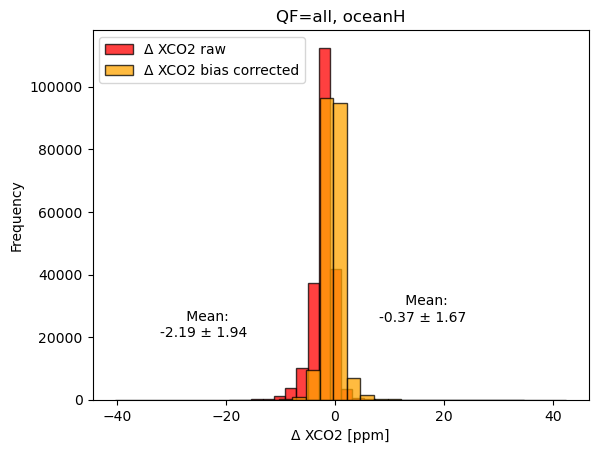

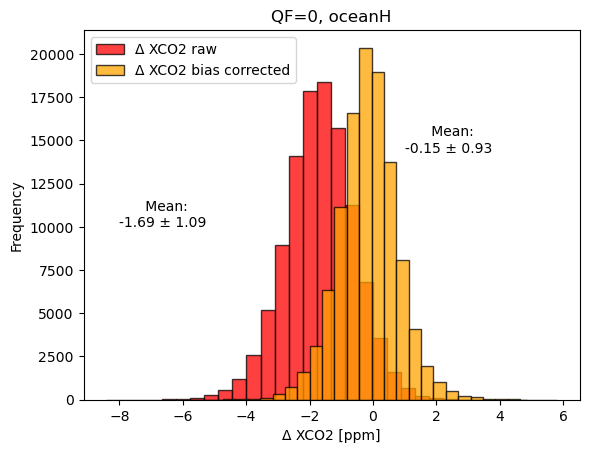

In [35]:
# Distribution of dxco2

# QF = all
plt.hist(data_df['dxco2_raw_ak_corrected_two_term'], bins=30, alpha = 0.75, color='red', edgecolor='black', label='Δ XCO2 raw') #, color='skyblue', edgecolor='black')
plt.hist(data_df['dxco2_bc_ak_corrected_two_term'], bins=30, alpha = 0.75, color='orange', edgecolor='black', label='Δ XCO2 bias corrected') #, color='skyblue', edgecolor='black')
plt.annotate(f'      Mean:\n{data_df['dxco2_raw_ak_corrected_two_term'].mean():.2f} ± {data_df['dxco2_raw_ak_corrected_two_term'].std():.2f}', xy=(5, 250), xytext=(-32, 20000), arrowprops=None)
plt.annotate(f'      Mean:\n{data_df['dxco2_bc_ak_corrected_two_term'].mean():.2f} ± {data_df['dxco2_bc_ak_corrected_two_term'].std():.2f}', xy=(5, 250), xytext=(8, 25000), arrowprops=None)
#plt.xlim(-30,30)
plt.legend(loc='upper left')
plt.xlabel('Δ XCO2 [ppm]')
plt.ylabel('Frequency')
plt.title(f'QF=all, {surface_type_string}{gain_string}')
plt.show()

# QF = 0
plt.hist(data_df_qf0['dxco2_raw_ak_corrected_two_term'], bins=30, alpha = 0.75, color='red', edgecolor='black', label='Δ XCO2 raw') #, color='skyblue', edgecolor='black')
plt.hist(data_df_qf0['dxco2_bc_ak_corrected_two_term'], bins=30, alpha = 0.75, color='orange', edgecolor='black', label='Δ XCO2 bias corrected') #, color='skyblue', edgecolor='black')
plt.annotate(f'      Mean:\n{data_df_qf0['dxco2_raw_ak_corrected_two_term'].mean():.2f} ± {data_df_qf0['dxco2_raw_ak_corrected_two_term'].std():.2f}', xy=(5, 250), xytext=(-8.0, 10000), arrowprops=None)
plt.annotate(f'      Mean:\n{data_df_qf0['dxco2_bc_ak_corrected_two_term'].mean():.2f} ± {data_df_qf0['dxco2_bc_ak_corrected_two_term'].std():.2f}', xy=(5, 250), xytext=(1.0, 14300), arrowprops=None)
#plt.xlim(-30,30)
plt.legend(loc='upper left')
plt.title(f'QF=0, {surface_type_string}{gain_string}')
plt.xlabel('Δ XCO2 [ppm]')
plt.ylabel('Frequency')
plt.show()

In [36]:
# define features
# features below are deemed the most important based on feature_importance_analysis.ipynb

landH = ['gosat_retrieval_dws',
             'gosat_retrieval_co2_grad_del',
             'gosat_retrieval_fs',
             'gosat_retrieval_aod_fine',
             'gosat_dp_abp',
             'gosat_h2o_ratio',
             'gosat_retrieval_albedo_wco2',
             'gosat_retrieval_albedo_slope_sco2',
             'gosat_retrieval_aod_strataer',
             'gosat_retrieval_eof1_3',
             #'gosat_retrieval_dpfrac',
             'gosat_retrieval_albedo_slope_o2a',
             'gosat_retrieval_water_height',
             'gosat_retrieval_rms_rel_wco2',
             'gosat_altitude_stddev',
             'gosat_retrieval_h2o_scale',
             'gosat_retrieval_dust_height',
             'gosat_retrieval_aod_ice',
             'gosat_retrieval_eof2_3',
             'gosat_retrieval_deltaT',  
#             'gosat_airmass',  
             'gosat_retrieval_offset_o2a_rel'] # Cut features here based on feature importance analysis
"""             'gosat_retrieval_ice_height', 
             'gosat_retrieval_aod_water',
             'gosat_retrieval_albedo_slope_wco2',
             'gosat_retrieval_chi2_o2a',
             'gosat_retrieval_rms_rel_sco2',
             'gosat_retrieval_tcwv_uncertainty',
             'gosat_retrieval_aod_seasalt',
             'gosat_land_fraction',
             'gosat_retrieval_aod_bc']"""

landM = ['gosat_retrieval_dws',
 'gosat_retrieval_dust_height',
 'gosat_retrieval_co2_grad_del',
 'gosat_retrieval_aod_strataer',
 'gosat_retrieval_albedo_sco2',
 'gosat_retrieval_aod_sulfate',
 'gosat_retrieval_dpfrac',
 'gosat_retrieval_eof2_3',
 'gosat_retrieval_eof1_3',
 'gosat_retrieval_s32',
 'gosat_retrieval_aod_ice',
 'gosat_h2o_ratio',
 'gosat_co2_ratio',
 'gosat_retrieval_ice_height',
 'gosat_retrieval_eof3_2',
 'gosat_retrieval_psurf',
 'gosat_retrieval_albedo_slope_wco2',
 'gosat_retrieval_tcwv_uncertainty']#,  Cut features here based on feature importance analysis
""" 'gosat_dp_abp',
 'gosat_glint_angle',
 'gosat_altitude_stddev',
 'gosat_retrieval_deltaT',
 'gosat_retrieval_water_height',
 'gosat_retrieval_albedo_slope_o2a',
 'gosat_retrieval_chi2_o2a',
 'gosat_retrieval_aod_water',
 'gosat_retrieval_h2o_scale',
 'gosat_retrieval_chi2_wco2',
 'gosat_retrieval_aod_seasalt',
 'gosat_land_fraction',
 'gosat_retrieval_aod_oc',
 'gosat_retrieval_aod_bc']"""

oceanH = ['gosat_retrieval_albedo_slope_sco2',
 'gosat_retrieval_co2_grad_del',
 'gosat_retrieval_eof3_3',
 'gosat_retrieval_albedo_slope_o2a',
 'gosat_retrieval_aod_fine',
 'gosat_dp_abp',
 'gosat_snr_o2a',
 'gosat_h2o_ratio',
 'gosat_retrieval_aod_water',
 'gosat_retrieval_albedo_sco2',
 'gosat_retrieval_aod_strataer',
 'gosat_retrieval_aod_dust',
 'gosat_co2_ratio',
 'gosat_retrieval_deltaT',
 'gosat_retrieval_dws',
 'gosat_retrieval_tcwv']    # Cut features here based on feature importance analysis
"""'gosat_retrieval_water_height',
 'gosat_retrieval_tcwv_uncertainty',
 'gosat_retrieval_h2o_scale',
 'gosat_retrieval_psurf',
 'gosat_retrieval_aod_oc',
 'gosat_retrieval_dust_height',
 'gosat_retrieval_chi2_o2a',
 'gosat_land_fraction',
 'gosat_altitude',
 'gosat_retrieval_aod_bc',
 'gosat_altitude_stddev']"""


features = oceanH   # Define which feature set to use
print(f'{len(features)} features')

16 features


In [37]:
# to check for data with NA's 
for col in data_df[features]:
  if np.any(data_df[col].isna()):
    print(col)

In [38]:
# Remove rows with missing/bad data 
if 'gosat_retrieval_fs' in features:  
    print(data_df.shape)
    data_df.drop(data_df.loc[data_df['gosat_retrieval_fs']==-999999.0].index, inplace=True)
    print(data_df.shape)
    
    print(data_df_qf0.shape)
    data_df_qf0.drop(data_df_qf0.loc[data_df_qf0['gosat_retrieval_fs']==-999999.0].index, inplace=True)
    print(data_df_qf0.shape)

# Use cross validation to tune hyperparameters

In [39]:
# Use cross-validation on the training set for hyperparameter turning 

from typing import Dict

# select which data to use as y variable
y_var = 'dxco2_raw_ak_corrected_two_term'  # 'dxco2_raw_ak_corrected_single_term'
train_years = [2014, 2015, 2016, 2017, 2018]  # hold out 2019 & 2020 for evaluation, or use all data for cross-validation  

qf_all = True  # False: use QF=0 data
if qf_all:
    cv_df = data_df
else: 
    cv_df = data_df_qf0
print(cv_df.shape)

model_dict = {}
mse_list, mae_list, r2_list = [], [], []
mse_list_train, mae_list_train, r2_list_train = [], [], []

alpha = np.array([0.16, 0.25, 0.5, 0.75, 0.84])  # quantiles to predict 

cv_df['y_pred_0.16'] = None  
cv_df['y_pred_0.25'] = None  
cv_df['y_pred_0.5'] = None  
cv_df['y_pred_0.75'] = None 
cv_df['y_pred_0.84'] = None  

for selected_year in train_years:
    print(f'Testing on: {selected_year}')

    x_train = cv_df[cv_df['gosat_year'] != selected_year][features]   
    x_test = cv_df[cv_df['gosat_year'] == selected_year][features]
    y_train = cv_df[cv_df['gosat_year'] != selected_year][y_var]
    y_test = cv_df[cv_df['gosat_year'] == selected_year][y_var]
    print(f'  X train: {x_train.shape}')
    print(f'  X test: {x_test.shape}')    
    
    evals_result: Dict[str, Dict] = {}
           
    Xy = xgb.QuantileDMatrix(x_train, y_train)
    # use Xy as a reference
    Xy_test = xgb.QuantileDMatrix(x_test, y_test, ref=Xy)

    booster = xgb.train(
        {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": alpha,
            "learning_rate": 0.08,
            "max_depth": 8,
            "reg_alpha": 10,    # L1 regularization  ### 5
            "reg_lambda": 1,  # L2 regularization   ### 1
            #"colsample_bytree": 0.80 
            "subsample": 0.80,
            #"verbosity":0
            #'silent': True
        },
        Xy,
        num_boost_round=100,
        early_stopping_rounds=2,
        # The evaluation result is a weighted average across multiple quantiles.
        evals=[(Xy, "Train"), (Xy_test, "Test")],
        evals_result=evals_result,
        verbose_eval=False
    )
    

    # Save training results
    #scores_train = booster.inplace_predict(x_train)
    scores_train = booster.predict(Xy, iteration_range=(0, booster.best_iteration + 1))
    y_med_train = scores_train[:, 2] 
    mse_list_train += [mse(y_train, y_med_train)]
    mae_list_train += [mae(y_train, y_med_train)]
    r2_list_train += [r2(y_train, y_med_train)]
    
    # Evaluate test set 
    #scores = booster.inplace_predict(x_test)
    scores = booster.predict(Xy_test, iteration_range=(0, booster.best_iteration + 1))
    # dim 1 is the quantiles
    assert scores.shape[0] == x_test.shape[0]
    assert scores.shape[1] == alpha.shape[0]
    
    y_med = scores[:, 2] 

    cv_df.loc[cv_df['gosat_year']==selected_year, 'y_pred_0.16'] = scores[:, 0]
    cv_df.loc[cv_df['gosat_year']==selected_year, 'y_pred_0.25'] = scores[:, 1]
    cv_df.loc[cv_df['gosat_year']==selected_year, 'y_pred_0.5'] = y_med
    cv_df.loc[cv_df['gosat_year']==selected_year, 'y_pred_0.75'] = scores[:, 3]
    cv_df.loc[cv_df['gosat_year']==selected_year, 'y_pred_0.84'] = scores[:, 4] 
    _mse = mse(y_test, y_med)
    _mae = mae(y_test, y_med)
    _r2 = r2(y_test, y_med)
    print(f'  MSE: {_mse:.2f}')
    print(f'  MAE: {_mae:.2f}')
    print(f'  R2: {_r2:.2f}')
    mse_list += [_mse]
    mae_list += [_mae]
    r2_list += [_r2]

    
    # save model
    model_dict[selected_year] = booster

print('\nTraining results')   
print(f'Ave MSE: {np.array(mse_list_train).mean():.2f} ± {np.array(mse_list_train).std():.2f}')
print(f'Ave RMSE: {np.sqrt(np.array(mse_list_train)).mean():.2f} ± {np.sqrt(np.array(mse_list_train)).std():.2f}')
print(f'Ave MAE: {np.array(mae_list_train).mean():.2f} ± {np.array(mae_list_train).std():.2f}')
print(f'Ave R2: {np.array(r2_list_train).mean():.2f} ± {np.array(r2_list_train).std():.2f}')

print('\nTesting results')
print(f'Ave MSE: {np.array(mse_list).mean():.2f} ± {np.array(mse_list).std():.2f}')
print(f'Ave RMSE: {np.sqrt(np.array(mse_list)).mean():.2f} ± {np.sqrt(np.array(mse_list)).std():.2f}')
print(f'Ave MAE: {np.array(mae_list).mean():.2f} ± {np.array(mae_list).std():.2f}')
print(f'Ave R2: {np.array(r2_list).mean():.2f} ± {np.array(r2_list).std():.2f}')

(210804, 245)
Testing on: 2014
  X train: (205297, 16)
  X test: (5507, 16)
  MSE: 1.27
  MAE: 0.88
  R2: 0.58
Testing on: 2015
  X train: (187753, 16)
  X test: (23051, 16)
  MSE: 1.18
  MAE: 0.85
  R2: 0.67
Testing on: 2016
  X train: (164403, 16)
  X test: (46401, 16)
  MSE: 0.84
  MAE: 0.65
  R2: 0.77
Testing on: 2017
  X train: (171735, 16)
  X test: (39069, 16)
  MSE: 0.91
  MAE: 0.67
  R2: 0.77
Testing on: 2018
  X train: (176140, 16)
  X test: (34664, 16)
  MSE: 0.85
  MAE: 0.66
  R2: 0.78

Training results
Ave MSE: 0.86 ± 0.09
Ave RMSE: 0.92 ± 0.05
Ave MAE: 0.66 ± 0.03
Ave R2: 0.77 ± 0.02

Testing results
Ave MSE: 1.01 ± 0.18
Ave RMSE: 1.00 ± 0.09
Ave MAE: 0.74 ± 0.10
Ave R2: 0.72 ± 0.08


In [45]:
# Evaluate on held out 2019 & 2020
val_years = [2019, 2020]
x_val = cv_df[cv_df['gosat_year'].isin(val_years)][features]
y_val = cv_df[cv_df['gosat_year'].isin(val_years)][y_var]
Xy_val = xgb.QuantileDMatrix(x_val, y_val, ref=Xy)

eval_scores = booster.predict(Xy_val, iteration_range=(0, booster.best_iteration + 1))

# dim 1 is the quantiles
assert eval_scores.shape[0] == x_test.shape[0]
assert eval_scores.shape[1] == alpha.shape[0]

y_med = eval_scores[:, 2]

print(f'Evaluation on held out years {val_years}:')
print(f'MSE: {mse(y_val, y_med):.2f}')
print(f'RMSE: {np.sqrt(mse(y_val, y_med)):.2f}')
print(f'MAE: {mae(y_val, y_med):.2f}')
print(f'R2: {r2(y_val, y_med):.2f}')

Evaluation on held out years [2019, 2020]:
MSE: 0.81
RMSE: 0.90
MAE: 0.66
R2: 0.78


In [47]:
cv_df.loc[:,'dxco2_ml_corrected'] = cv_df[y_var] - cv_df['y_pred_0.5'].astype(float)
cv_df.loc[:,'gosat_ml_corrected'] = cv_df['gosat_retrieval_xco2_raw'] - cv_df['y_pred_0.5'].astype(float)
cv_df.loc[:,'gosat_ml_corrected_uncertainty'] = (cv_df['y_pred_0.84'].astype(float) - 
                                                 cv_df['y_pred_0.16'].astype(float))/2

# set type to float
cv_df.loc[:,'dxco2_ml_corrected'] = pd.to_numeric(cv_df['dxco2_ml_corrected'], errors='coerce')
cv_df.loc[:,'gosat_ml_corrected'] = pd.to_numeric(cv_df['gosat_ml_corrected'], errors='coerce')
cv_df.loc[:,'gosat_ml_corrected_uncertainty'] = pd.to_numeric(cv_df['gosat_ml_corrected_uncertainty'], errors='coerce')

#data_df_qf0 = data_df[data_df['gosat_xco2_quality_flag']==0]
data_df_cv = cv_df[data_df['gosat_year'].isin(train_years)]  
print(f'CV - QF = all: {data_df_cv.shape}')


data_df_qf0_cv = cv_df[(cv_df['gosat_xco2_quality_flag']==0) & (cv_df['gosat_year'].isin(train_years))]  
print(f'CV - QF = 0: {data_df_qf0_cv.shape}')

CV - QF = all: (148692, 253)
CV - QF = 0: (78847, 253)


# Once hyperparameters are tuned, train a single model with the chosen parameters

In [53]:
# Train a single model combining several years of test data

# https://xgboost.readthedocs.io/en/stable/python/examples/quantile_regression.html
from typing import Dict

# which variable to use as y
y_var = 'dxco2_raw_ak_corrected_two_term' 

train_years = [2014, 2015, 2016, 2017]
test_years = [2018]
val_years = [2019, 2020] 

if qf_all:
    x_train = data_df[data_df['gosat_year'].isin(train_years)][features]
    x_val = data_df[data_df['gosat_year'].isin(val_years)][features]
    x_test = data_df[data_df['gosat_year'].isin(test_years)][features]    
    y_train = data_df[data_df['gosat_year'].isin(train_years)][y_var]
    y_val = data_df[data_df['gosat_year'].isin(val_years)][y_var]
    y_test = data_df[data_df['gosat_year'].isin(test_years)][y_var]
else:
    x_train = data_df_qf0[data_df_qf0['gosat_year'].isin(train_years)][features]
    x_val = data_df_qf0[data_df_qf0['gosat_year'].isin(val_years)][features]    
    x_test = data_df_qf0[data_df_qf0['gosat_year'].isin(test_years)][features]    
    y_train = data_df_qf0[data_df_qf0['gosat_year'].isin(train_years)][y_var]
    y_val = data_df_qf0[data_df_qf0['gosat_year'].isin(val_years)][y_var]
    y_test = data_df_qf0[data_df_qf0['gosat_year'].isin(test_years)][y_var]

# Quantiles to train on
alpha = np.array([0.16, 0.25, 0.5, 0.75, 0.84])
data_df['y_pred_0.16'] = None  
data_df['y_pred_0.25'] = None  
data_df['y_pred_0.5'] = None  
data_df['y_pred_0.75'] = None 
data_df['y_pred_0.84'] = None 

# Train on every quantile
evals_result: Dict[str, Dict] = {}

# Using the `hist` tree method, quantile DMatrix can be used to preserve
# memory (which has nothing to do with quantile regression itself, see its document
# for details).

Xy = xgb.QuantileDMatrix(x_train, y_train)
# use Xy as a reference
Xy_test = xgb.QuantileDMatrix(x_test, y_test, ref=Xy)
Xy_val = xgb.QuantileDMatrix(x_val, y_val, ref=Xy)

#{'reg_lambda': 20, 'reg_alpha': 1, 'max_depth': 6, 'learning_rate': 0.05}

_booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        "learning_rate": 0.10,
        "max_depth": 8,
        "reg_alpha": 5,    # L1 regularization
        "reg_lambda": 1,  # L2 regularization
        #"colsample_bytree": 0.80 
        "subsample": 0.80,
        #"verbosity":0
        #'silent': True
    },
    Xy,
    num_boost_round=100,
    early_stopping_rounds=2,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
    verbose_eval=False
)

# Evaluate on training set
train_scores = _booster.predict(Xy, iteration_range=(0, _booster.best_iteration + 1))

y_med_train = train_scores[:, 2]  

print('\nTraining:')
print(f'  MSE: {mse(y_train, y_med_train):.2f}')
print(f'  RMSE: {np.sqrt(mse(y_train, y_med_train)):.2f}')
print(f'  MAE: {mae(y_train, y_med_train):.2f}')
print(f'  R2: {r2(y_train, y_med_train):.2f}')

# Evaluate on validation set
#scores = _booster.inplace_predict(x_val)
scores = _booster.predict(Xy_val, iteration_range=(0, _booster.best_iteration + 1))

y_med = scores[:,2]
# dim 1 is the quantiles
assert scores.shape[0] == x_val.shape[0]
assert scores.shape[1] == alpha.shape[0]

print('\nValidation:')
print(f'  MSE: {mse(y_val, y_med):.2f}')
print(f'  RMSE: {np.sqrt(mse(y_val, y_med)):.2f}')
print(f'  MAE: {mae(y_val, y_med):.2f}')
print(f'  R2: {r2(y_val, y_med):.2f}')


Training:
  MSE: 0.72
  RMSE: 0.85
  MAE: 0.59
  R2: 0.81

Validation:
  MSE: 1.09
  RMSE: 1.04
  MAE: 0.80
  R2: 0.71


# Save the final model

In [54]:
# Define model name
model_name = 'oceanH_qf=all_train2014-2017_eval2018.json'
#model_name = 'landH_qf=all_train2014-2017_eval2018.json'
#model_name = 'landM_qf=all_train2014-2017_eval2018.josn'

model_fn = os.path.join(model_dir, model_name)
_booster.save_model(model_fn)

print(f'Saved model to {model_fn}')

Saved model to C:\Users\hopki\Projects\gosat_oco2\models\oceanH_qf=all_train2014-2017_eval2018.json


In [58]:
# Calculate ML corrected GOSAT
data_df.loc[:,'dxco2_ml_corrected'] = data_df[y_var] - data_df['y_pred_0.5'].astype(float)
data_df.loc[:,'dxco2_ml_corrected'] = pd.to_numeric(data_df['dxco2_ml_corrected'], errors='coerce')

# Evaluate the calibration of the predicted quantiles

In [60]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [62]:
#train_scores = booster.inplace_predict(x_train)
#train_scores = _booster.predict(Xy, iteration_range=(0, _booster.best_iteration + 1))

train_coverage = coverage_fraction(
    y_train,
    train_scores[:, 0], # alpha=0.16
    train_scores[:, 4]   # alpha=0.84 
)
    
print(f'{train_coverage*100:.2f}% of the training samples fall within the {(alpha[4] - alpha[0])*100}% CI')

val_coverage = coverage_fraction(
    y_val,
    eval_scores[:, 0], # alpha=0.16
    eval_scores[:, 4]  # alpha=0.84 
)
print(f'{val_coverage*100:.2f}% of the testing samples fall within the {(alpha[4] - alpha[0])*100}% CI')

68.54% of the training samples fall within the 68.0% CI
67.22% of the testing samples fall within the 68.0% CI


In [64]:
train_coverage = coverage_fraction(
    y_train,
    train_scores[:, 1], # alpha=0.25
    train_scores[:, 3]   # alpha=0.75 
)
print(f'{train_coverage*100:.2f}% of the training samples fall within the lower {(alpha[3] - alpha[1])*100}% CI')

val_coverage = coverage_fraction(
    y_val,
    eval_scores[:, 1], # alpha=0.25
    eval_scores[:, 3]  # alpha=0.75 
)
print(f'{val_coverage*100:.2f}% of the testing samples fall within the lower {(alpha[3] - alpha[1])*100}% CI')

50.46% of the training samples fall within the lower 50.0% CI
49.18% of the testing samples fall within the lower 50.0% CI


In [ ]:
# TODO: ECE Plot

# Evaluate CV results

In [ ]:
# plot R2 for QF=0

y_ml_cv = data_df_cv['y_pred_0.5'].astype(float).values
y_cv = data_df_cv[y_var].values

y_stacked_cv = np.vstack([y_cv, y_ml_cv])
z_cv = gaussian_kde(y_stacked_cv)(y_stacked_cv)

r2_score_all_cv = r2(y_cv, y_ml_cv)

plt.figure(figsize=(6, 6))
plt.scatter(y_cv, y_ml_cv, c=z_cv)
plt.xlabel('Observed ΔXCO2 [ppm]')
plt.ylabel('ML corrected ΔXCO2 [ppm]')
plt.xlim(-30, 20)
plt.ylim(-30, 20)
ax = plt.subplot()
ax.axline((0, 0), slope=1, color='black')
plt.title(f'{surface_type_string + gain_string}, QF=all')
plt.annotate(f'R² = {r2_score_all_cv:.2f}' , xy=(0.02, 0.95), xycoords='axes fraction', fontsize=13)
plt.show()

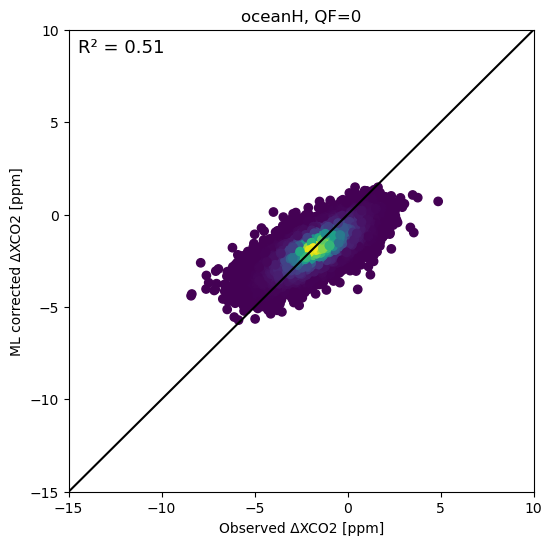

In [65]:
# plot R2 for QF=0

y_ml_cv_qf0 = data_df_qf0_cv['y_pred_0.5'].astype(float).values
y_cv_qf0 = data_df_qf0_cv[y_var].values

y_stacked_cv_qf0 = np.vstack([y_ml_cv_qf0, y_cv_qf0])
z_cv_qf0 = gaussian_kde(y_stacked_cv_qf0)(y_stacked_cv_qf0)

r2_score_all = r2(y_cv_qf0, y_ml_cv_qf0)

plt.figure(figsize=(6, 6))
plt.scatter(y_cv_qf0, y_ml_cv_qf0, c=z_cv_qf0)
plt.xlabel('Observed ΔXCO2 [ppm]')
plt.ylabel('ML corrected ΔXCO2 [ppm]')
plt.xlim(-15, 10)
plt.ylim(-15, 10)
ax = plt.subplot()
ax.axline((0, 0), slope=1, color='black')
plt.title(f'{surface_type_string + gain_string}, QF=0')
plt.annotate(f'R² = {r2_score_all:.2f}' , xy=(0.02, 0.95), xycoords='axes fraction', fontsize=13)
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'dxco2_r2_cv_{surface_type_string + gain_string}_QF=0.png'), bbox_inches='tight')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

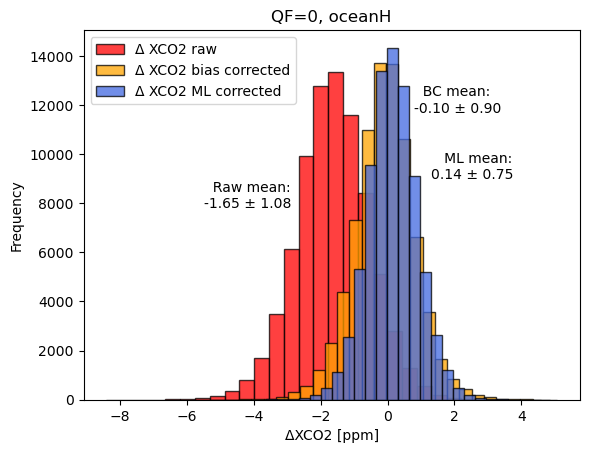

In [77]:
"""# Histograms of ΔXCO2 - LandH, QF = all
plt.hist(data_df_cv['dxco2_raw_ak_corrected_single_term'], bins=30, alpha = 0.75, color='red', edgecolor='black', label='Δ XCO2 raw') #, color='skyblue', edgecolor='black')
plt.hist(data_df_cv['dxco2_bc_ak_corrected_single_term'], bins=30, alpha = 0.75, color='orange', edgecolor='black', label='Δ XCO2 bias corrected') #, color='skyblue', edgecolor='black')
plt.hist(data_df_cv['dxco2_ml_corrected'], bins=30, alpha = 0.75, color='royalblue', edgecolor='black', label='Δ XCO2 ML corrected')
plt.annotate(f'  Raw mean:\n{data_df_cv['dxco2_raw_ak_corrected_single_term'].mean():.2f} ± {data_df_cv['dxco2_raw_ak_corrected_single_term'].std():.2f}', xy=(5, 250), xytext=(-14, 40000), arrowprops=None)
plt.annotate(f'   BC mean:\n{data_df_cv['dxco2_bc_ak_corrected_single_term'].mean():.2f} ± {data_df_cv['dxco2_bc_ak_corrected_single_term'].std():.2f}', xy=(5, 250), xytext=(-10, 60000), arrowprops=None)
plt.annotate(f'   ML mean:\n{data_df_cv['dxco2_ml_corrected'].mean():.2f} ± {data_df_cv['dxco2_ml_corrected'].std():.2f}', xy=(5, 250), xytext=(2.5, 55000), arrowprops=None)
plt.legend()
plt.xlabel('Δ XCO2 [ppm]')
plt.ylabel('Frequency')
plt.title('LandH, QF = all')
plt.xlim(-20,20)
plt.show()


# Histograms of ΔXCO2 - LandH , QF = all
plt.hist(data_df_qf0_cv['dxco2_raw_ak_corrected_single_term'], bins=30, alpha = 0.75, color='red', edgecolor='black', label='Δ XCO2 raw') #, color='skyblue', edgecolor='black')
plt.hist(data_df_qf0_cv['dxco2_bc_ak_corrected_single_term'], bins=30, alpha = 0.75, color='orange', edgecolor='black', label='Δ XCO2 bias corrected') #, color='skyblue', edgecolor='black')
plt.hist(data_df_qf0_cv['dxco2_ml_corrected'], bins=30, alpha = 0.75, color='royalblue', edgecolor='black', label='Δ XCO2 ML corrected')
plt.annotate(f'  Raw mean:\n{data_df_qf0_cv['dxco2_raw_ak_corrected_single_term'].mean():.2f} ± {data_df_qf0_cv['dxco2_raw_ak_corrected_single_term'].std():.2f}', xy=(5, 250), xytext=(-8.5, 7800), arrowprops=None)
plt.annotate(f'  BC mean:\n{data_df_qf0_cv['dxco2_bc_ak_corrected_single_term'].mean():.2f} ± {data_df_qf0_cv['dxco2_bc_ak_corrected_single_term'].std():.2f}', xy=(5, 250), xytext=(-6, 10000), arrowprops=None)
plt.annotate(f'   ML mean:\n{data_df_qf0_cv['dxco2_ml_corrected'].mean():.2f} ± {data_df_qf0_cv['dxco2_ml_corrected'].std():.2f}', xy=(5, 250), xytext=(1.5, 9800), arrowprops=None)
plt.legend()
plt.xlabel('ΔXCO2 [ppm]')
plt.ylabel('Frequency')
plt.title('LandH, QF = 0')
plt.show"""

# Histograms of ΔXCO2 - LandH , QF = 0
plt.hist(data_df_qf0_cv['dxco2_raw_ak_corrected_two_term'], bins=30, alpha = 0.75, color='red', edgecolor='black', label='Δ XCO2 raw') #, color='skyblue', edgecolor='black')
plt.hist(data_df_qf0_cv['dxco2_bc_ak_corrected_two_term'], bins=30, alpha = 0.75, color='orange', edgecolor='black', label='Δ XCO2 bias corrected') #, color='skyblue', edgecolor='black')
plt.hist(data_df_qf0_cv['dxco2_ml_corrected'], bins=30, alpha = 0.75, color='royalblue', edgecolor='black', label='Δ XCO2 ML corrected')
plt.annotate(f'  Raw mean:\n{data_df_qf0_cv['dxco2_raw_ak_corrected_two_term'].mean():.2f} ± {data_df_qf0_cv['dxco2_raw_ak_corrected_two_term'].std():.2f}', xy=(5, 250), xytext=(-5.5, 7800), arrowprops=None)
plt.annotate(f'  BC mean:\n{data_df_qf0_cv['dxco2_bc_ak_corrected_two_term'].mean():.2f} ± {data_df_qf0_cv['dxco2_bc_ak_corrected_two_term'].std():.2f}', xy=(5, 250), xytext=(0.8, 11700), arrowprops=None)
plt.annotate(f'   ML mean:\n{data_df_qf0_cv['dxco2_ml_corrected'].mean():.2f} ± {data_df_qf0_cv['dxco2_ml_corrected'].std():.2f}', xy=(5, 250), xytext=(1.3, 9000), arrowprops=None)
plt.legend()
plt.xlabel('ΔXCO2 [ppm]')
plt.ylabel('Frequency')
plt.title(f'QF=0, {surface_type_string}{gain_string}')
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'dxco2_histogram_{surface_type_string + gain_string}_QF=0.png'), bbox_inches='tight')
plt.show

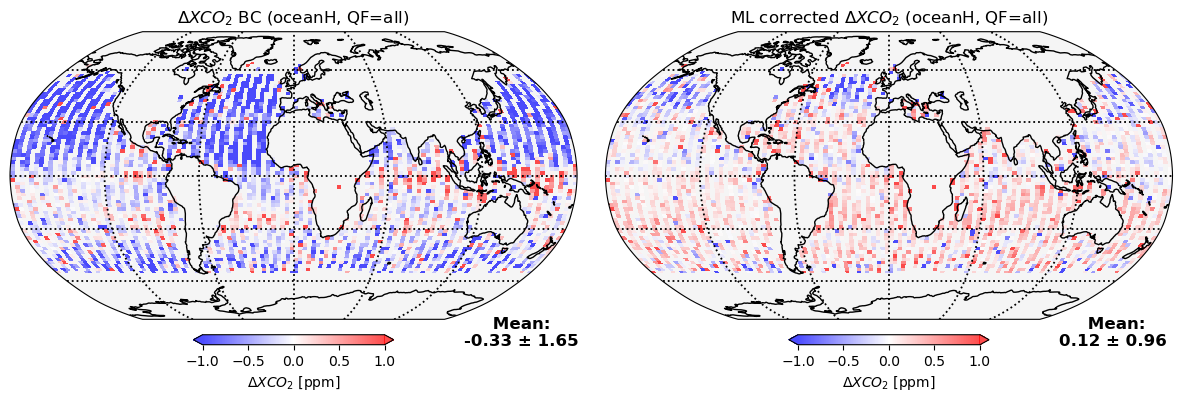

In [67]:
# Spatial plot of errors - QF = all 

y_ml_cv = data_df_cv['dxco2_ml_corrected'].values
y_bc_cv = data_df_cv['dxco2_bc_ak_corrected_two_term'].values

fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.05, wspace=0.05)
axs = axs.ravel()
#letters = ["a)","b)"]

r1, xedges, yedges = np.histogram2d(data_df_cv['gosat_longitude'],data_df_cv['gosat_latitude'],bins=[360//3, 180//3])


d1, _, _, = np.histogram2d(data_df_cv['gosat_longitude'],data_df_cv['gosat_latitude'],bins=[xedges, yedges], weights=(y_bc_cv))

d1[d1==0.0] = np.nan
binned_dxco2_post_pred = d1 / r1

im = axs[0].imshow(binned_dxco2_post_pred.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
#axs[0].text(0.02, 0.99, letters[0], 
#        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=18, weight = 'bold')
axs[0].text(0.8, 0.01, f'     Mean: \n{y_bc_cv.mean():.2f} ± {y_bc_cv.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('whitesmoke')
axs[0].set_title(fr'$\Delta XCO_{2}$ BC ({surface_type_string}{gain_string}, {model_string})', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


d1, _, _, = np.histogram2d(data_df_cv['gosat_longitude'],data_df_cv['gosat_latitude'],bins=[xedges, yedges], weights=(y_ml_cv))

d1[d1==0.00000] = np.nan
binned_bc_uncert_bc = d1 / r1

im = axs[1].imshow(binned_bc_uncert_bc.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr',vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
#axs[1].text(0.02, 0.99, letters[1], 
#        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=18, weight = 'bold')
axs[1].text(0.8, 0.01, f'     Mean: \n{y_ml_cv.mean():.2f} ± {y_ml_cv.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('whitesmoke')
axs[1].set_title(fr'ML corrected $\Delta XCO_{2}$ ({surface_type_string}{gain_string}, {model_string})', fontsize=12)

fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'dxco2_global_cv_{surface_type_string + gain_string}_QF=all.png'), bbox_inches='tight')

plt.show()

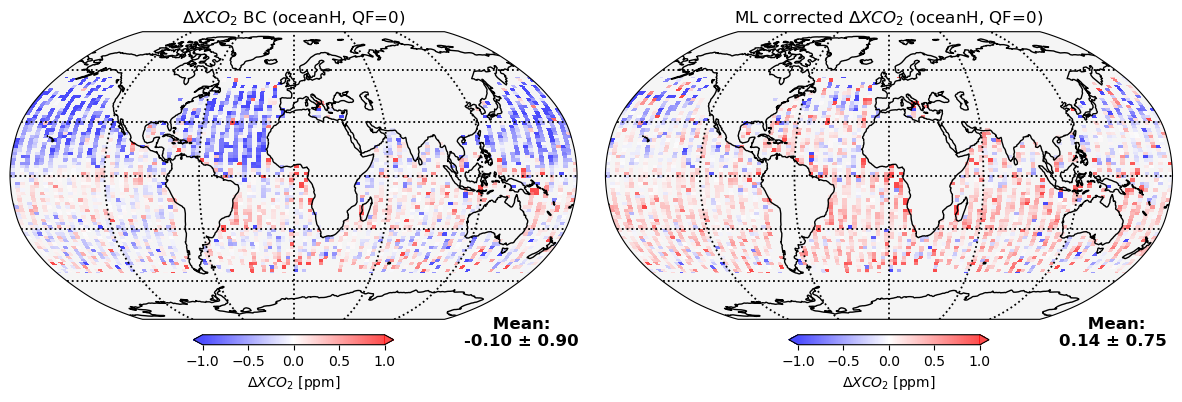

In [68]:
# Spatial plot of errors - QF = 0 

y_ml_cv_qf0 = data_df_qf0_cv['dxco2_ml_corrected'].values
y_bc_cv_qf0 = data_df_qf0_cv['dxco2_bc_ak_corrected_two_term'].values

fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.05, wspace=0.05)
axs = axs.ravel()
#letters = ["a)","b)"]

r1, xedges, yedges = np.histogram2d(data_df_qf0_cv['gosat_longitude'],data_df_qf0_cv['gosat_latitude'],bins=[360//3, 180//3])


d1, _, _, = np.histogram2d(data_df_qf0_cv['gosat_longitude'],data_df_qf0_cv['gosat_latitude'],bins=[xedges, yedges], weights=(y_bc_cv_qf0))

d1[d1==0.0] = np.nan
binned_dxco2_post_pred = d1 / r1

im = axs[0].imshow(binned_dxco2_post_pred.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
#axs[0].text(0.02, 0.99, letters[0], 
#        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=18, weight = 'bold')
axs[0].text(0.8, 0.01, f'     Mean: \n{y_bc_cv_qf0.mean():.2f} ± {y_bc_cv_qf0.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('whitesmoke')
axs[0].set_title(fr'$\Delta XCO_{2}$ BC ({surface_type_string}{gain_string}, QF=0)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


d1, _, _, = np.histogram2d(data_df_qf0_cv['gosat_longitude'],data_df_qf0_cv['gosat_latitude'],bins=[xedges, yedges], weights=(y_ml_cv_qf0))

d1[d1==0.00000] = np.nan
binned_bc_uncert_bc = d1 / r1

im = axs[1].imshow(binned_bc_uncert_bc.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'bwr',vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
#axs[1].text(0.02, 0.99, letters[1], 
#        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=18, weight = 'bold')
axs[1].text(0.8, 0.01, f'     Mean: \n{y_ml_cv_qf0.mean():.2f} ± {y_ml_cv_qf0.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('whitesmoke')
axs[1].set_title(fr'ML corrected $\Delta XCO_{2}$ ({surface_type_string}{gain_string}, QF=0)', fontsize=12)

fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'dxco2_global_cv_{surface_type_string + gain_string}_QF=0.png'), bbox_inches='tight')

plt.show()

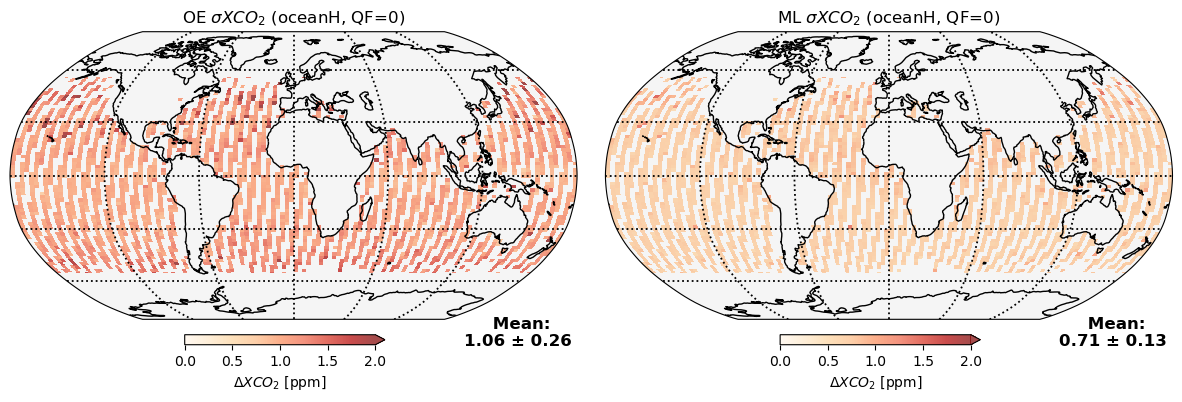

In [69]:
# Spatial plot of uncertainty - QF = 0 
operational_uq = data_df_qf0_cv['gosat_xco2_uncertainty'].values
y_ml_uq_qf0 = data_df_qf0_cv['gosat_ml_corrected_uncertainty'].values
#y_bc_cv_qf0 = data_df_qf0_cv['dxco2_bc_ak_corrected_two_term'].values

fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.05, wspace=0.05)
axs = axs.ravel()
#letters = ["a)","b)"]

r1, xedges, yedges = np.histogram2d(data_df_qf0_cv['gosat_longitude'],data_df_qf0_cv['gosat_latitude'],bins=[360//3, 180//3])


d1, _, _, = np.histogram2d(data_df_qf0_cv['gosat_longitude'],data_df_qf0_cv['gosat_latitude'],bins=[xedges, yedges], weights=(operational_uq))

d1[d1==0.0] = np.nan
binned_dxco2_post_pred = d1 / r1

im = axs[0].imshow(binned_dxco2_post_pred.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'OrRd', vmin=0, vmax=2, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
#axs[0].text(0.02, 0.99, letters[0], 
#        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=18, weight = 'bold')
axs[0].text(0.8, 0.01, f'     Mean: \n{operational_uq.mean():.2f} ± {operational_uq.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=12, weight = 'bold')
axs[0].set_facecolor('whitesmoke')
axs[0].set_title(fr'OE $\sigma XCO_{2}$ ({surface_type_string}{gain_string}, QF=0)', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label=r'$\Delta XCO_{2}$ [ppm]')


d1, _, _, = np.histogram2d(data_df_qf0_cv['gosat_longitude'],data_df_qf0_cv['gosat_latitude'],bins=[xedges, yedges], weights=(y_ml_uq_qf0))

d1[d1==0.00000] = np.nan
binned_bc_uncert_bc = d1 / r1

im = axs[1].imshow(binned_bc_uncert_bc.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'OrRd',vmin=0, vmax=2, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
#axs[1].text(0.02, 0.99, letters[1], 
#        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=18, weight = 'bold')
axs[1].text(0.8, 0.01, f'     Mean: \n{y_ml_uq_qf0.mean():.2f} ± {y_ml_uq_qf0.std():.2f}', 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=12, weight = 'bold')
axs[1].set_facecolor('whitesmoke')
axs[1].set_title(fr'ML $\sigma XCO_{2}$ ({surface_type_string}{gain_string}, QF=0)', fontsize=12)

fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label=r'$\Delta XCO_{2}$ [ppm]')
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'xco2_uq_global_cv_{surface_type_string + gain_string}_QF=0.png'), bbox_inches='tight')

plt.show()

In [70]:
from datetime import datetime

"""data_df.loc[:,'datestring'] = data_df['gosat_year'].astype(str) + '-' + \
                   data_df['gosat_month'].astype(str).str.zfill(2) + '-' + \
                   data_df['gosat_day'].astype(str).str.zfill(2)"""
data_df_cv.loc[:,'datestring'] = data_df_cv['gosat_year'].astype(str) + '-' + \
                   data_df_cv['gosat_month'].astype(str).str.zfill(2) + '-' + \
                   data_df_cv['gosat_day'].astype(str).str.zfill(2)
data_df_qf0_cv.loc[:,'datestring'] = data_df_qf0_cv['gosat_year'].astype(str) + '-' + \
                   data_df_qf0_cv['gosat_month'].astype(str).str.zfill(2) + '-' + \
                   data_df_qf0_cv['gosat_day'].astype(str).str.zfill(2)

#data_df.loc[:,'datetime'] = pd.to_datetime(data_df['datestring'], format='%Y-%m-%d')
data_df_cv.loc[:,'datetime'] = pd.to_datetime(data_df_cv['datestring'], format='%Y-%m-%d')
data_df_qf0_cv.loc[:,'datetime'] = pd.to_datetime(data_df_qf0_cv['datestring'], format='%Y-%m-%d')

(556,)
(556,)
(556,)


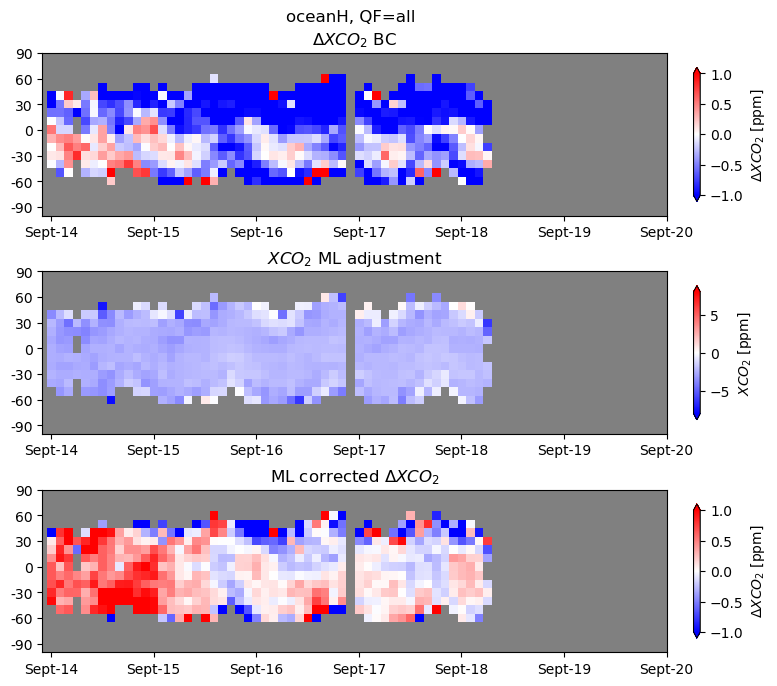

In [71]:
# Hovmoller plot of biases - QF = all data

#temp = pd.concat([data_df, empty_df])
y_ml_cv = data_df_cv['dxco2_ml_corrected'].values
y_ml_adjust_cv = data_df_cv['y_pred_0.5'].astype(float).values
y_bc_cv = data_df_cv['dxco2_bc_ak_corrected_single_term'].values  #dxco2_bc_ak_corrected_two_term
y_bc_no_ak_cv = data_df_cv['dxco2_bc'].values

lat_bin = np.arange(-90,100,10)
ytick = [0, 3, 6, 9, 12, 15, 18]
ytick_labels = [-90, -60, -30, 0, 30, 60, 90]
xtick = np.arange(0,80,12)  
xtick_labels = ['Sept-14', 'Sept-15', 'Sept-16', 'Sept-17', 'Sept-18', 'Sept-19', 'Sept-20']

legend_min, legend_max = -1, 1

fig, axs = plt.subplots(3, 1, figsize=(8, 7)) 
plt.suptitle(f'{surface_type_string}{gain_string}, {model_string}', x=0.46, y=0.97, fontsize=12)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(data_df_cv['datetime'],
                                    data_df_cv['gosat_latitude'],
                                    bins=[52, lat_bin]) # 70 bins for full record (70 months) --> 52 for 2014-2018


# ΔXCO2 (BC GOSAT - OCO-2) w/ak
d1, _, _, = np.histogram2d(data_df_cv['datetime'],
                           data_df_cv['gosat_latitude'],
                           bins=[xedges, yedges], weights=(y_bc_cv))

d1[d1==0.0] = np.nan
print(np.where(~np.isnan(d1))[0].shape)
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
            cmap = 'bwr', vmin=legend_min, vmax=legend_max)
axs[0].set_xlim(-1, 70) 
axs[0].set_ylim(-1, 12)
axs[0].set_facecolor('grey')
axs[0].set_yticks(ytick)
axs[0].set_yticklabels(ytick_labels)
axs[0].set_xticks(xtick)
axs[0].set_xticklabels(xtick_labels)
axs[0].set_title(r'$\Delta XCO_{2}$ BC', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='vertical', fraction=0.01, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# ML-predicted adjsutment to GOSAT
d1, _, _, = np.histogram2d(data_df_cv['datetime'],
                           data_df_cv['gosat_latitude'],
                           bins=[xedges, yedges], weights=(y_ml_adjust_cv))
d1[d1==0.0] = np.nan
print(np.where(~np.isnan(d1))[0].shape)
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
            cmap = 'bwr', vmin=-8, vmax=8)
#           extent=[0, 180*4, -90, 90], cmap = 'seismic', vmin=-2, vmax=2) 
axs[1].set_xlim(-1, 70)  # Set x-axis limits from 0 to 5
axs[1].set_ylim(-1, 12)
axs[1].set_facecolor('grey')
axs[1].set_yticks(ytick)
axs[1].set_yticklabels(ytick_labels)
axs[1].set_xticks(xtick)
axs[1].set_xticklabels(xtick_labels)
axs[1].set_title(r'$XCO_{2}$ ML adjustment', fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.01, pad=0.04, extend='both', label=r'$XCO_{2}$ [ppm]')

# ML-adjusted ΔXCO2 (ML GOSAT - OCO-2)
d1, _, _, = np.histogram2d(data_df_cv['datetime'],
                           data_df_cv['gosat_latitude'],
                           bins=[xedges, yedges], weights=(y_ml_cv))
d1[d1==0.0] = np.nan
print(np.where(~np.isnan(d1))[0].shape)
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
            cmap = 'bwr', vmin=legend_min, vmax=legend_max)
axs[2].set_xlim(-1, 70)  # Set x-axis limits from 0 to 5
axs[2].set_ylim(-1, 12)
axs[2].set_facecolor('grey')
axs[2].set_yticks(ytick)
axs[2].set_yticklabels(ytick_labels)
axs[2].set_xticks(xtick)
axs[2].set_xticklabels(xtick_labels)
axs[2].set_title(r'ML corrected $\Delta XCO_{2}$', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='vertical', fraction=0.01, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')

plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'dxco2_hovmuller_cv_{surface_type_string + gain_string}_QF=all.png'), bbox_inches='tight')
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
C:\Users\hopki\AppData\Local\Temp\ipykernel_19360\4158091602.py:26: SyntaxWarning: invalid escape sequence '\D'
  """# ΔXCO2 (BC GOSAT - OCO-2) w/out ak


(498,)
(498,)
(498,)


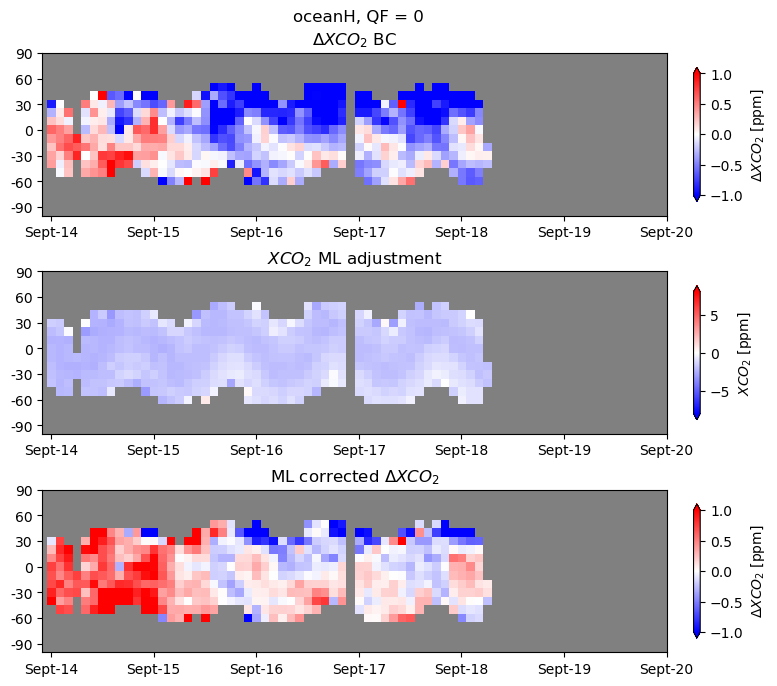

In [72]:
# Hovmoller plot of biases - QF = all data

y_ml_cv_qf0 = data_df_qf0_cv['dxco2_ml_corrected'].values
y_ml_adjust_cv_qf0 = data_df_qf0_cv['y_pred_0.5'].astype(float).values
y_bc_cv_qf0 = data_df_qf0_cv['dxco2_bc_ak_corrected_single_term'].values  #dxco2_bc_ak_corrected_two_term
y_bc_no_ak_cv_qf0 = data_df_qf0_cv['dxco2_bc'].values

lat_bin = np.arange(-90,100,10)
ytick = [0, 3, 6, 9, 12, 15, 18]
ytick_labels = [-90, -60, -30, 0, 30, 60, 90]
xtick = np.arange(0,80,12)
xtick_labels = ['Sept-14', 'Sept-15', 'Sept-16', 'Sept-17', 'Sept-18', 'Sept-19', 'Sept-20']

legend_min, legend_max = -1, 1

fig, axs = plt.subplots(3, 1, figsize=(8, 7)) 
plt.suptitle(f'{surface_type_string}{gain_string}, QF = 0', x=0.47, y=0.97, fontsize=12)
axs = axs.ravel()

r1, xedges, yedges = np.histogram2d(data_df_qf0_cv['datetime'],
                                    data_df_qf0_cv['gosat_latitude'],
                                    bins=[52, lat_bin])  # 70 bins for full record (70 months) --> 52 for 2014-2018


# ΔXCO2 (BC GOSAT - OCO-2) w/ak
#d1, _, _, = np.histogram2d(data_df['datetime'],data_df['gosat_latitude'],bins=[xedges, yedges], weights=(y_bc))
d1, _, _, = np.histogram2d(data_df_qf0_cv['datetime'],
                           data_df_qf0_cv['gosat_latitude'],
                           bins=[xedges, yedges], weights=(y_bc_cv_qf0))

d1[d1==0.0] = np.nan
print(np.where(~np.isnan(d1))[0].shape)
binned_dxco2 = d1 / r1

im = axs[0].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
            cmap = 'bwr', vmin=legend_min, vmax=legend_max)
axs[0].set_xlim(-1, 70) 
axs[0].set_ylim(-1, 12)
axs[0].set_facecolor('grey')
axs[0].set_yticks(ytick)
axs[0].set_yticklabels(ytick_labels)
axs[0].set_xticks(xtick)
axs[0].set_xticklabels(xtick_labels)
axs[0].set_title(r'$\Delta XCO_{2}$ BC', fontsize=12)
fig.colorbar(im, ax=axs[0], orientation='vertical', fraction=0.01, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')


# ML-predicted adjsutment to GOSAT
d1, _, _, = np.histogram2d(data_df_qf0_cv['datetime'],
                           data_df_qf0_cv['gosat_latitude'],
                           bins=[xedges, yedges], weights=(y_ml_adjust_cv_qf0))
d1[d1==0.0] = np.nan
print(np.where(~np.isnan(d1))[0].shape)
binned_dxco2 = d1 / r1

im = axs[1].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
            cmap = 'bwr', vmin=-8, vmax=8)
#           extent=[0, 180*4, -90, 90], cmap = 'seismic', vmin=-2, vmax=2) 
axs[1].set_xlim(-1, 70)  # Set x-axis limits from 0 to 5
axs[1].set_ylim(-1, 12)
axs[1].set_facecolor('grey')
#ax.set_xticklabels(['Sep-14', 'Sep-15', 'Sep-16', 'Sep-17', 'Sep-18', 'Sep-19']) #, 'Sep-20'])
#ax.set_yticks([-39.62696838, 17.87784118652344, 68.19454956])
axs[1].set_yticks(ytick)
axs[1].set_yticklabels(ytick_labels)
axs[1].set_xticks(xtick)
axs[1].set_xticklabels(xtick_labels)
axs[1].set_title(r'$XCO_{2}$ ML adjustment', fontsize=12)
#axs[1].text(0.5, 1.2, r'$XCO_{2}$ ML adjustment [ppm]', 
#        verticalalignment='top', horizontalalignment='center',  transform=axs[1].transAxes, fontsize=12)
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.01, pad=0.04, extend='both', label=r'$XCO_{2}$ [ppm]')

# ML-adjusted ΔXCO2 (ML GOSAT - OCO-2)
d1, _, _, = np.histogram2d(data_df_qf0_cv['datetime'],
                           data_df_qf0_cv['gosat_latitude'],
                           bins=[xedges, yedges], weights=(y_ml_cv_qf0))
d1[d1==0.0] = np.nan
print(np.where(~np.isnan(d1))[0].shape)
binned_dxco2 = d1 / r1

im = axs[2].imshow(binned_dxco2.T, interpolation='nearest', origin='lower',
            cmap = 'bwr', vmin=legend_min, vmax=legend_max)
#           extent=[0, 180*4, -90, 90], cmap = 'seismic', vmin=-2, vmax=2) 
axs[2].set_xlim(-1, 70)  # Set x-axis limits from 0 to 5
axs[2].set_ylim(-1, 12)
axs[2].set_facecolor('grey')
#ax.set_xticklabels(['Sep-14', 'Sep-15', 'Sep-16', 'Sep-17', 'Sep-18', 'Sep-19']) #, 'Sep-20'])
axs[2].set_yticks(ytick)
axs[2].set_yticklabels(ytick_labels)
axs[2].set_xticks(xtick)
axs[2].set_xticklabels(xtick_labels)
axs[2].set_title(r'ML corrected $\Delta XCO_{2}$', fontsize=12)
fig.colorbar(im, ax=axs[2], orientation='vertical', fraction=0.01, pad=0.04, extend='both', label=r'$\Delta XCO_{2}$ [ppm]')

plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(plot_dir, f'dxco2_hovmuller_cv_{surface_type_string + gain_string}_QF=0.png'), bbox_inches='tight')

plt.show()

# Mean interaction plots

In [50]:
#Quality filter ranges are defined in the DUG: https://docserver.gesdisc.eosdis.nasa.gov/public/project/OCO/OCO2_V11_OCO3_V10_DUG.pdf

plot_params_land = {'gosat_retrieval_dws': {'name': 'dws',
                                           'x_range': [0, 0.45],
                                           'QF_range': [0, 0.2]},
 'gosat_retrieval_fs': {'name': 'fs',
                        'x_range': [-1,1],  #[-1, 3.5],   
                        'QF_range': []},  
 'gosat_retrieval_aod_fine': {'name': 'aod_fine',  # Retrieval/aod_sulfate + Retrieval/aod_oc [0.0.15]; both are highly correlated w/ aod_fine
                              'x_range': [0, 0.37],
                              'QF_range': []},
 'gosat_retrieval_albedo_wco2': {'name': 'albedo_wco2',
                                 'x_range': [0.05, 0.53],
                                 'QF_range': []},
 'gosat_retrieval_co2_grad_del': {'name': 'co2_grad_del',
                                  'x_range': [-70, 110],
                                  'QF_range': [-90, 90 ]},
 'gosat_retrieval_aod_strataer': {'name': 'aod_strataer',
                                  'x_range': [0, 0.06],
                                  'QF_range': [1e-4, 0.025]},
 'gosat_h2o_ratio': {'name': 'h2o_ratio',
                     'x_range': [0.6, 1.6],
                     'QF_range': [0.75, 1.07]},
 'gosat_retrieval_eof1_3': {'name': 'eof1_3',
                            'x_range': [-0.1, 0.12],
                            'QF_range': []},
 'gosat_retrieval_albedo_slope_o2a': {'name': 'albedo_slope_o2a',
                                      'x_range': [-0.00005, 0.00007],
                                      'QF_range': []},
 'gosat_retrieval_dust_height': {'name': 'dust_height',
                                         'x_range': [0.6, 1.1],
                                         'QF_range': []},
 'gosat_dp_abp': {'name': 'dp_abp',
                          'x_range': [-0.01, 0.45],
                          'QF_range': [-15, 12]},
 'gosat_retrieval_aod_ice': {'name': 'aod_ice',
                                     'x_range': [],
                                     'QF_range': [8e-5, 0.04]},
 'gosat_retrieval_dp': {'name': 'dp',
                                'x_range': [-0.01, 0.45],
                                'QF_range': []},
 'gosat_altitude_stddev': {'name': 'altitude_stddev',
                                   'x_range': [],
                                   'QF_range': []},
 'gosat_retrieval_eof2_3': {'name': 'eof2_3',
                                    'x_range': [],
                                    'QF_range': []},
 'gosat_retrieval_water_height': {'name': 'water_height',
                                          'x_range': [],
                                          'QF_range': []},
 'gosat_retrieval_albedo_slope_sco2': {'name': 'albedo_slope_sco2',
                                               'x_range': [],
                                               'QF_range': []},
 'gosat_retrieval_rms_rel_wco2': {'name': 'rms_rel_wco2',
                                          'x_range': [],
                                          'QF_range': []},
 'gosat_retrieval_h2o_scale': {'name': 'h2o_scale',
                                       'x_range': [],
                                       'QF_range': []},
 'gosat_retrieval_t700': {'name': 't700',
                                  'x_range': [],
                                  'QF_range': []}}

In [51]:
import math 

def mean_interaction(x, y, num_bins):
  x_mean = []
  y_mean = []
  y_std = []
  
  #num_bins = math.ceil((x.max() - x.min()) / bin_width)
  hist, bin_edges = np.histogram(x, bins=num_bins)
  bin_width = (x.max() - x.min()) / num_bins
  for lower_edge in bin_edges:     
    data_mask = np.logical_and(x >= lower_edge, x < (lower_edge + bin_width))
    #print(y[data_mask])
    #print(y[data_mask].mean())
    x_mean.append(np.mean([lower_edge, lower_edge + bin_width]))
    y_mean.append(y[data_mask].mean())
    y_std.append(y[data_mask].std())
  return np.array(x_mean), np.array(y_mean), np.array(y_std)

C:\Users\hopki\AppData\Local\Temp\ipykernel_31404\351732614.py:16: RuntimeWarning: Mean of empty slice.
  y_mean.append(y[data_mask].mean())
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods

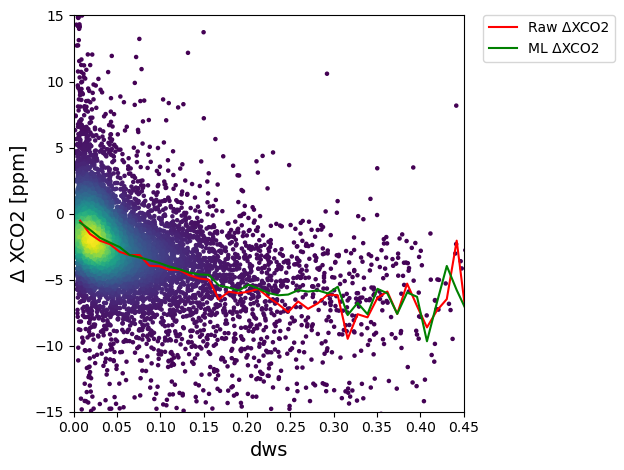

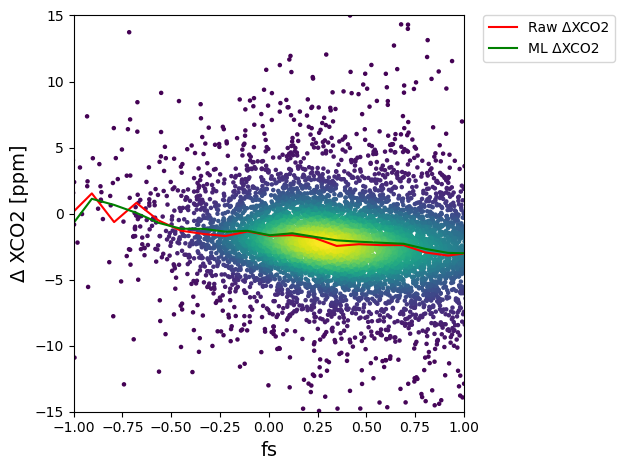

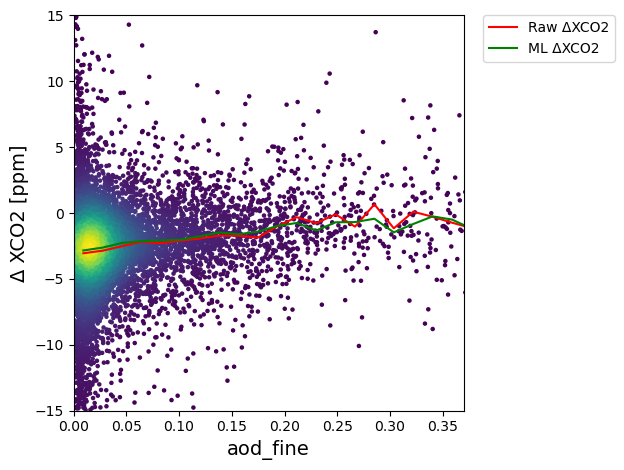

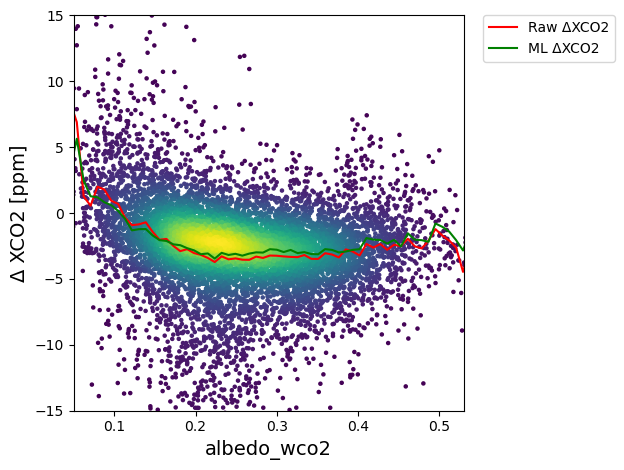

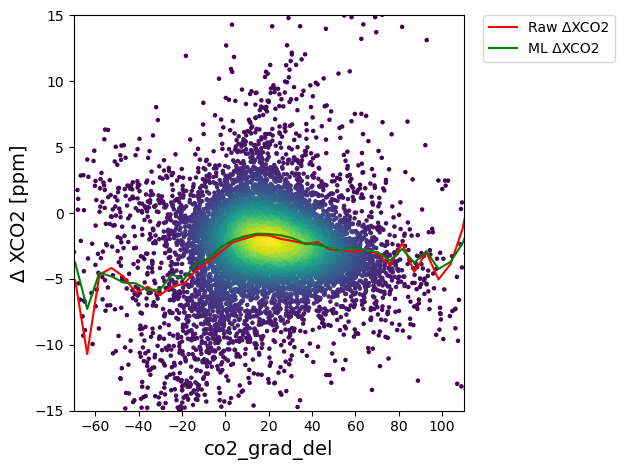

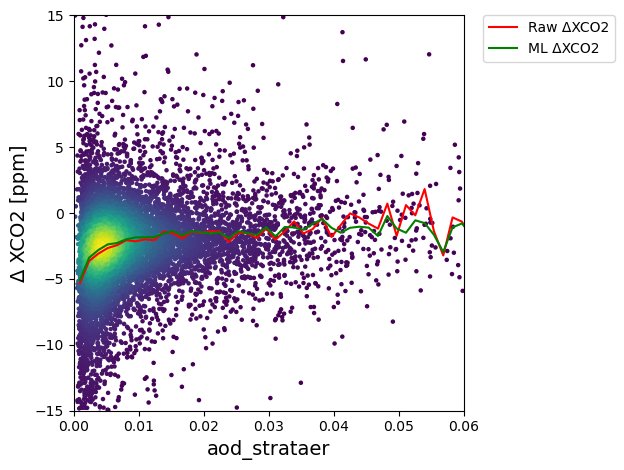

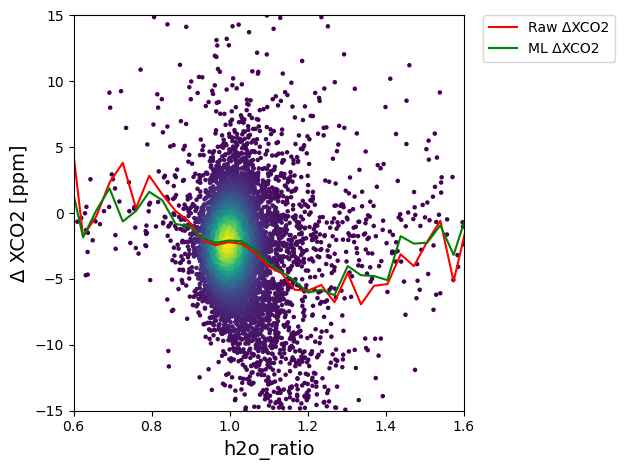

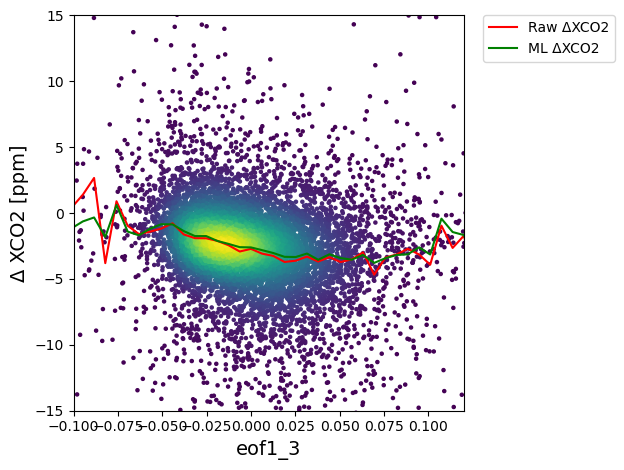

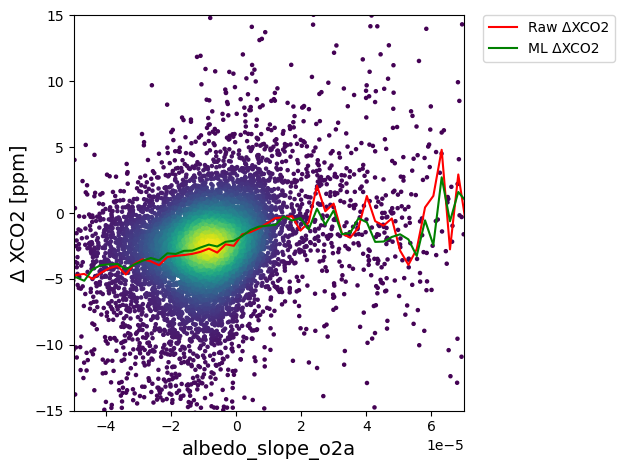

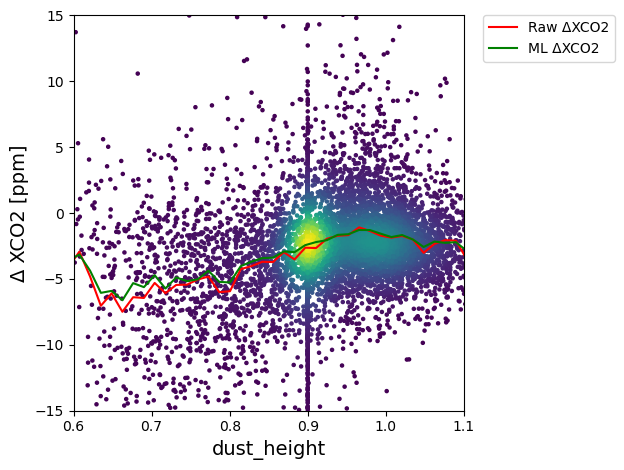

In [52]:
# Evaluate ML predictions; plot actual ΔXCO2 and predicted ΔXCO2 (these should appear similar)  

selected_year = 2019
count = 0
for feat in features:
    if feat == 'gosat_year':
        continue
    if count > 9:  # Only plot the top 9 features
        break
    #to_plot = x_test[feat].values
    to_plot = data_df[data_df['gosat_year'] == selected_year][feat].values
    y_test = data_df[data_df['gosat_year'] == selected_year][y_var].values
    y_med = data_df[data_df['gosat_year'] == selected_year]['y_pred_med'].values.astype(np.float32)
    y_upper = data_df[data_df['gosat_year'] == selected_year]['y_pred_upper'].values.astype(np.float32)
    y_lower = data_df[data_df['gosat_year'] == selected_year]['y_pred_lower'].values.astype(np.float32)

    y_stacked = np.vstack([to_plot, y_test])
    z = gaussian_kde(y_stacked)(y_stacked)
    plt.scatter(to_plot, y_test, c=z, s=5) #, label='Test observations')
    
    
    # Raw delta
    y_raw = data_df[data_df['gosat_year'] == selected_year]['dxco2_raw_ak_corrected_single_term'].values
    x_mean_raw, y_mean_raw, y_std_raw = mean_interaction(to_plot, y_raw, num_bins=75)
    plt.plot(x_mean_raw, y_mean_raw, color='red', label='Raw ΔXCO2')
    #plt.fill_between(x_mean_raw, y_mean_raw-2*y_std_raw, y_mean_raw+2*y_std_raw, alpha=0.2, edgecolor='red', facecolor='red')
    
    # ML-predicted delta
    x_mean_ml, y_mean_ml, _ = mean_interaction(to_plot, y_med, num_bins=75)
    x_mean_lower, y_mean_lower, _ = mean_interaction(to_plot, y_lower, num_bins=75)
    x_mean_upper, y_mean_upper, _ = mean_interaction(to_plot, y_upper, num_bins=75)
    plt.plot(x_mean_ml, y_mean_ml, color='green', label='ML ΔXCO2')
    #plt.plot(x_mean_lower, y_mean_lower, color='green', linewidth = 0.5)
    #plt.plot(x_mean_upper, y_mean_upper, color='green', linewidth = 0.5)
    #plt.fill_between(x_mean_ml, y_mean_lower,y_mean_upper, alpha=0.2, edgecolor='green', facecolor='green')


    plt.xlabel(plot_params_land[feat]['name'], fontsize=14)
    plt.ylabel('Δ XCO2 [ppm]', fontsize=14)
    plt.ylim(-15, 15)
    plt.xlim(plot_params_land[feat]['x_range'])
    #plt.legend(loc='upper right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout() # Adjust layout to prevent legend overlap
    
    plt.show()
    count += 1

C:\Users\hopki\AppData\Local\Temp\ipykernel_31404\351732614.py:16: RuntimeWarning: Mean of empty slice.
  y_mean.append(y[data_mask].mean())
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hopki\miniconda3\envs\harmonize_env\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


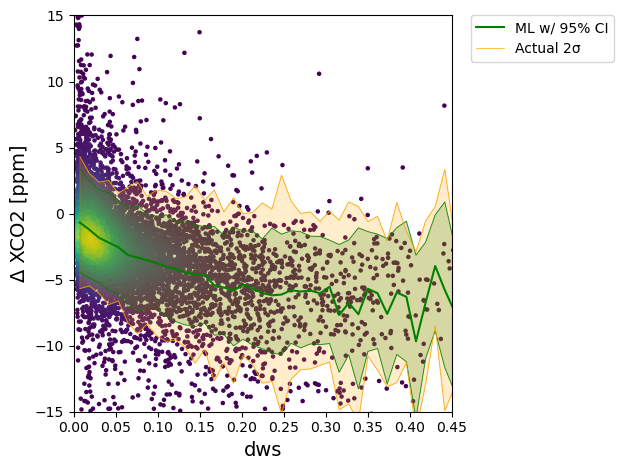

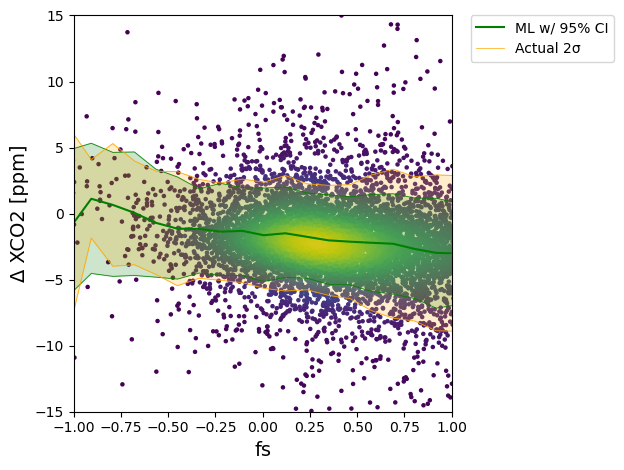

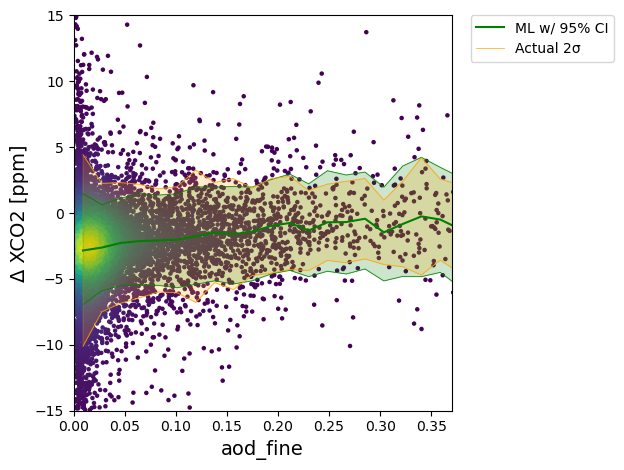

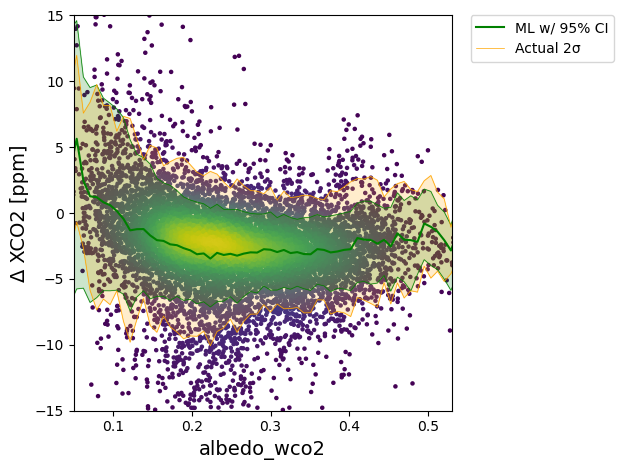

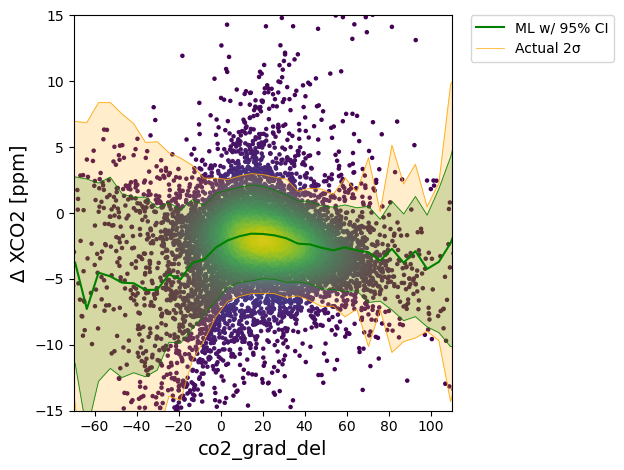

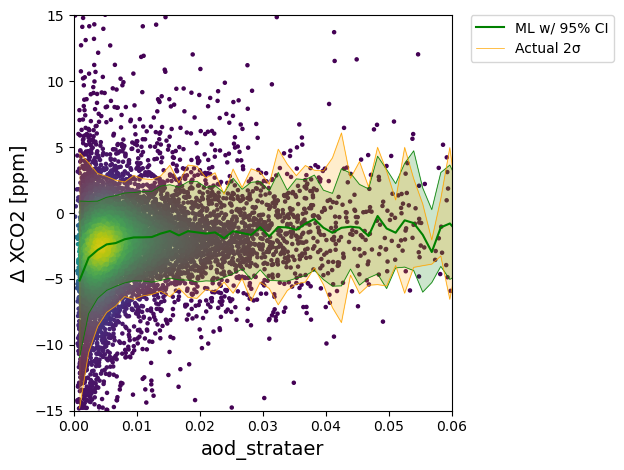

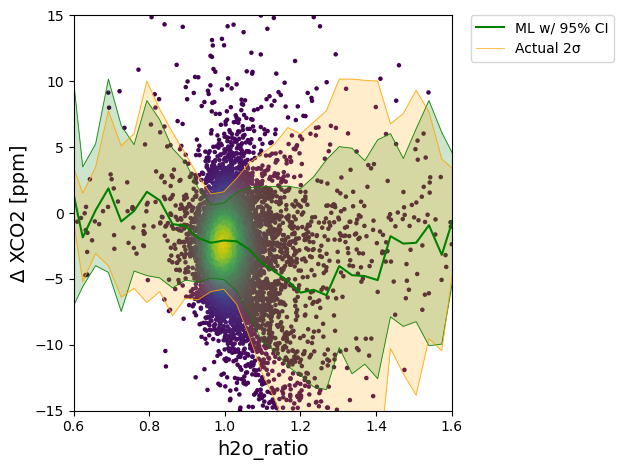

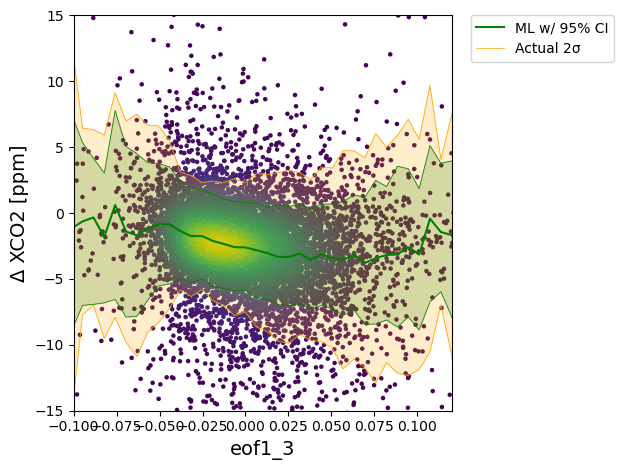

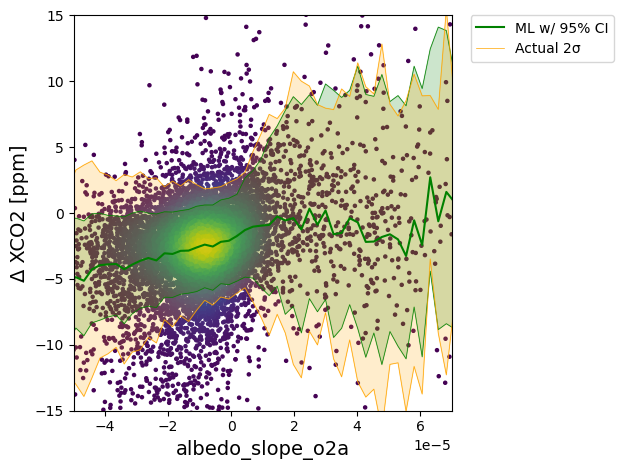

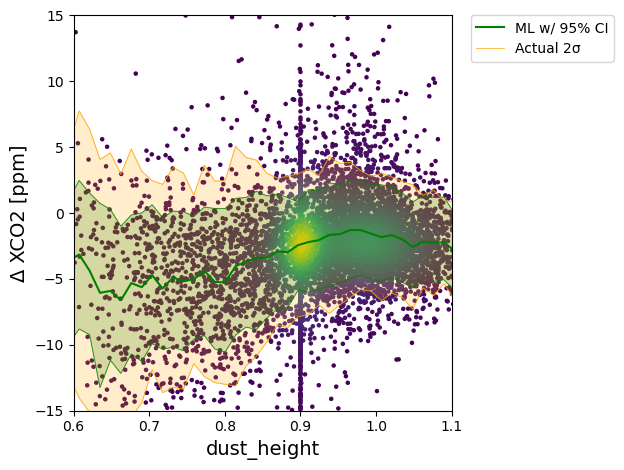

In [22]:
# Evaluate predicted quantiles; plot predicted ΔXCO2 and predicted 95% CIs and compare to actual 2σ

selected_year = 2019
count = 0
for feat in features:
    if feat == 'gosat_year':
        continue
    if count > 9:  # Only plot the top 9 features
        break
    #to_plot = x_test[feat].values
    to_plot = data_df[data_df['gosat_year'] == selected_year][feat].values
    y_test = data_df[data_df['gosat_year'] == selected_year][y_var].values
    y_ml = data_df[data_df['gosat_year'] == selected_year]['y_pred_med'].values.astype(np.float32)
    y_upper = data_df[data_df['gosat_year'] == selected_year]['y_pred_upper'].values.astype(np.float32)
    y_lower = data_df[data_df['gosat_year'] == selected_year]['y_pred_lower'].values.astype(np.float32)


    y_stacked = np.vstack([to_plot, y_test])
    z = gaussian_kde(y_stacked)(y_stacked)
    plt.scatter(to_plot, y_test, c=z, s=5) #, label='Test observations')
    
    
    # ML-predicted 
    x_mean_ml, y_mean_ml, y_std_ml = mean_interaction(to_plot, y_ml, num_bins=75)
    x_mean_lower, y_mean_lower, _ = mean_interaction(to_plot, y_lower, num_bins=75)
    x_mean_upper, y_mean_upper, _ = mean_interaction(to_plot, y_upper, num_bins=75)
    plt.plot(x_mean_ml, y_mean_ml, color='green', label='ML w/ 95% CI')
    plt.plot(x_mean_lower, y_mean_lower, color='green', linewidth = 0.5)
    plt.plot(x_mean_upper, y_mean_upper, color='green', linewidth = 0.5)
    plt.fill_between(x_mean_ml, y_mean_lower,y_mean_upper, alpha=0.2, edgecolor='green', facecolor='green')

    # Real 2σ 
    _, _, y_std_ml = mean_interaction(to_plot, y_ml, num_bins=75)
    plt.plot(x_mean_ml, y_mean_ml-2*y_std_ml, color='orange', linewidth = 0.5, label='Actual 2σ')
    plt.plot(x_mean_ml, y_mean_ml+2*y_std_ml, color='orange', linewidth = 0.5)
    plt.fill_between(x_mean_ml, y_mean_ml-2*y_std_ml, y_mean_ml+2*y_std_ml, alpha=0.2, edgecolor='orange', facecolor='orange')

    plt.xlabel(plot_params_land[feat]['name'], fontsize=14)
    plt.ylabel('Δ XCO2 [ppm]', fontsize=14)
    plt.ylim(-15, 15)
    plt.xlim(plot_params_land[feat]['x_range'])
    #plt.legend(loc='upper right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout() # Adjust layout to prevent legend overlap
    
    plt.show()
    count += 1

C:\Users\hopki\AppData\Local\Temp\ipykernel_31404\351732614.py:16: RuntimeWarning: Mean of empty slice.
  y_mean.append(y[data_mask].mean())


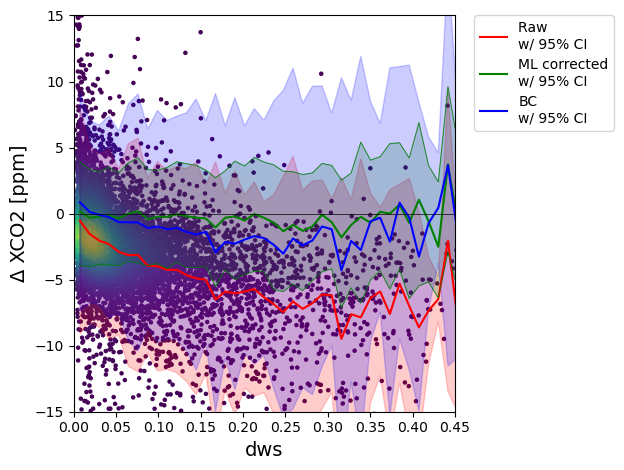

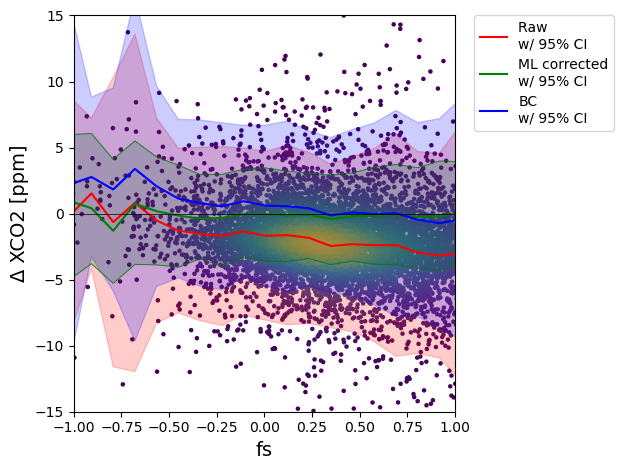

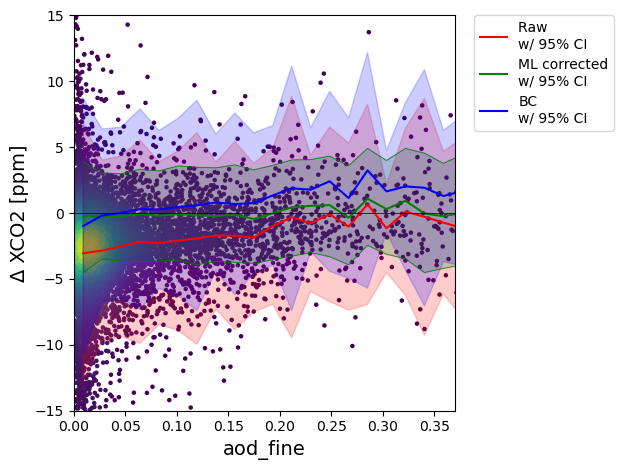

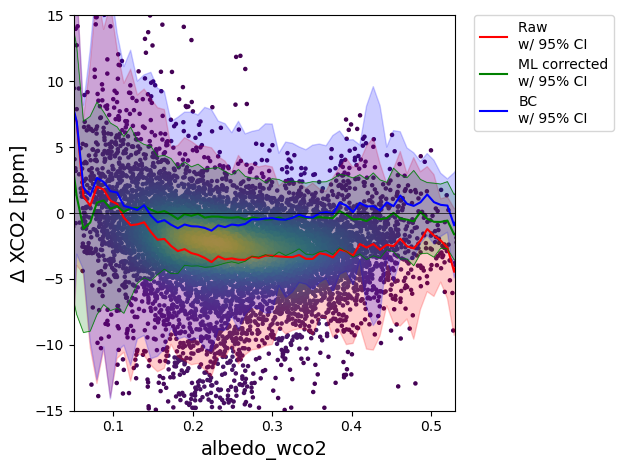

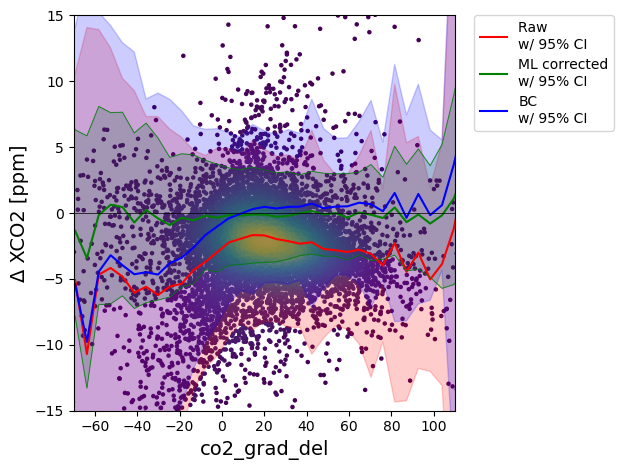

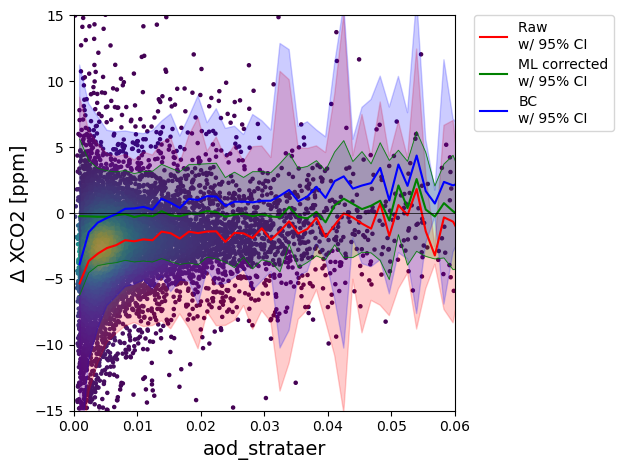

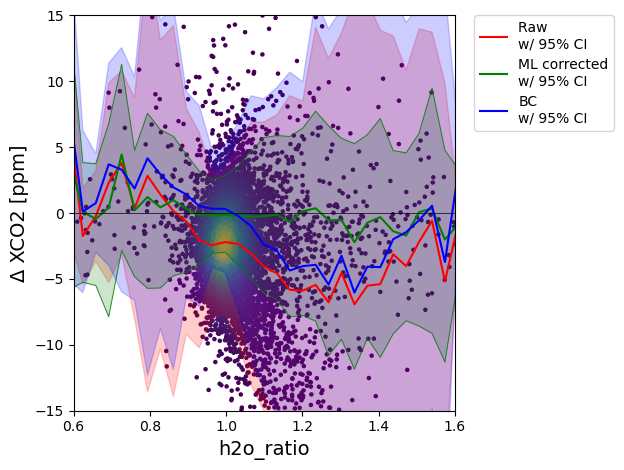

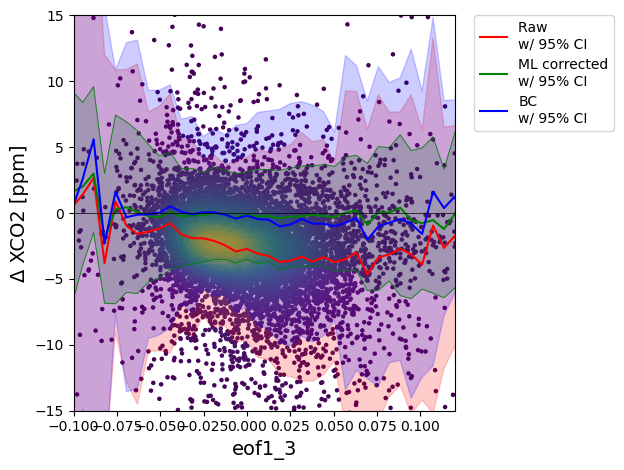

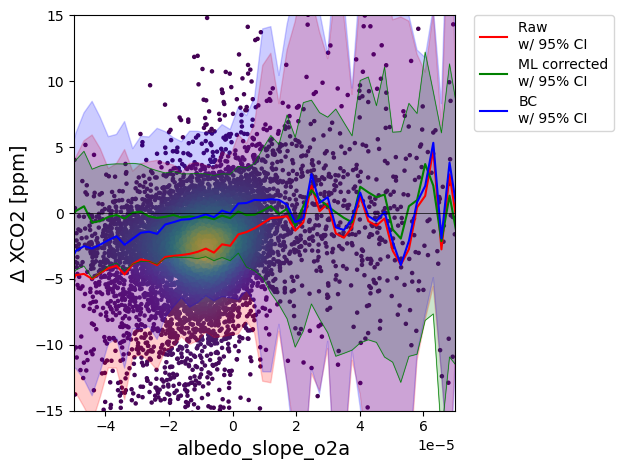

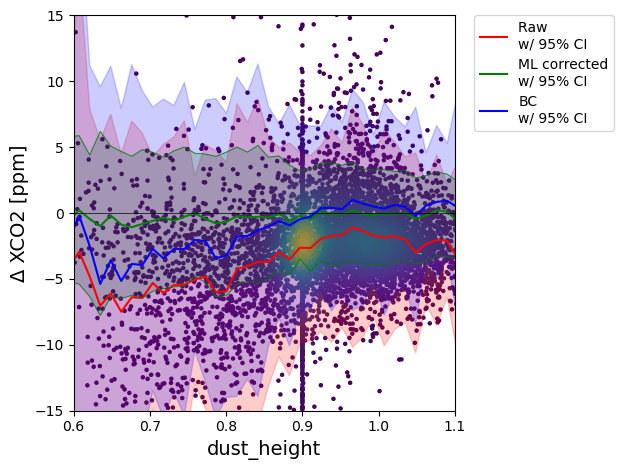

In [25]:
# Evaluate ML predictions; plot actual ΔXCO2 and predicted ΔXCO2 (these should appear similar)  

selected_year = 2019
count = 0
for feat in features:
    if feat == 'gosat_year':
        continue
    if count > 9:  # Only plot the top 9 features
        break
    #to_plot = x_test[feat].values
    to_plot = data_df[data_df['gosat_year'] == selected_year][feat].values
    y_test = data_df[data_df['gosat_year'] == selected_year][y_var].values
    y_ml = data_df[data_df['gosat_year'] == selected_year]['dxco2_ml_corrected'].values.astype(np.float32)
    #y_med = data_df[data_df['gosat_year'] == selected_year]['y_pred_med'].values.astype(np.float32)
    y_upper = data_df[data_df['gosat_year'] == selected_year]['dxco2_ml_corrected_upper'].values.astype(np.float32)
    y_lower = data_df[data_df['gosat_year'] == selected_year]['dxco2_ml_corrected_lower'].values.astype(np.float32)

    y_stacked = np.vstack([to_plot, y_test])
    z = gaussian_kde(y_stacked)(y_stacked)
    plt.scatter(to_plot, y_test, c=z, s=5) #, label='Test observations')
    
    
    # Raw delta
    y_raw = data_df[data_df['gosat_year'] == selected_year]['dxco2_raw_ak_corrected_single_term'].values
    x_mean_raw, y_mean_raw, y_std_raw = mean_interaction(to_plot, y_raw, num_bins=75)
    plt.plot(x_mean_raw, y_mean_raw, color='red', label='Raw \nw/ 95% CI')
    plt.fill_between(x_mean_raw, y_mean_raw-2*y_std_raw, y_mean_raw+2*y_std_raw, alpha=0.2, edgecolor='red', facecolor='red')
    
    # ML-predicted delta
    x_mean_ml, y_mean_ml, _ = mean_interaction(to_plot, y_ml, num_bins=75)
    x_mean_lower, y_mean_lower, _ = mean_interaction(to_plot, y_lower, num_bins=75)
    x_mean_upper, y_mean_upper, _ = mean_interaction(to_plot, y_upper, num_bins=75)
    plt.plot(x_mean_ml, y_mean_ml, color='green', label='ML corrected\nw/ 95% CI')
    plt.plot(x_mean_lower, y_mean_lower, color='green', linewidth = 0.5)
    plt.plot(x_mean_upper, y_mean_upper, color='green', linewidth = 0.5)
    plt.fill_between(x_mean_ml, y_mean_lower,y_mean_upper, alpha=0.2, edgecolor='green', facecolor='green')

    # BC
    y_bc = data_df[data_df['gosat_year'] == selected_year]['dxco2_bc_ak_corrected_single_term']
    x_mean_bc, y_mean_bc, y_std_bc = mean_interaction(to_plot, y_bc, num_bins=75)
    plt.plot(x_mean_bc, y_mean_bc, color='blue', label='BC\nw/ 95% CI')
    plt.fill_between(x_mean_bc, y_mean_bc-2*y_std_bc, y_mean_bc+2*y_std_bc, alpha=0.2, edgecolor='blue', facecolor='blue')

    plt.axhline(y=0, color='black', linewidth=0.5)

    plt.xlabel(plot_params_land[feat]['name'], fontsize=14)
    plt.ylabel('Δ XCO2 [ppm]', fontsize=14)
    plt.ylim(-15, 15)
    plt.xlim(plot_params_land[feat]['x_range'])
    #plt.legend(loc='upper right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout() # Adjust layout to prevent legend overlap
    
    plt.show()
    count += 1